An introductory project to Text Classification techniques in a product setting. The goal of this project was to explore industry-wide used packages for breaking down textual data and then building simple classification models for sentiment text analysis. I was also curious to explore common phrases and words individuals use when reviewing these types of products.The dataset comes from Amazon, which holds a small repository of product reviews for a variety of product classes. I chose to analyze technology related product reviews.

In [1]:
import pandas as pd
import nltk.stem as stm 
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from sklearn import utils
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import Sequential
from keras.layers import Dense

C:\Users\pbibra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# Data Cleaning and Exploration

Fortunately, the data set provided the full product review, a numerical rating (on a scale of 1-5, with 5 representing a strong product), and a condensed summary of the rating. The datasets were already split into positive and negative reviews.

In [2]:
pos_data = pd.read_csv('pos_test_2.csv')
is_string_dtype(pos_data['text'])

True

In [3]:
pos_data = pd.read_csv('pos_test_2.csv')

In [4]:
pos_data.head()

,text
0,{'text': 'These stickers work like the review ...
1,{'text': 'These are awesome and make my phone ...
2,"{'text': 'awesome! stays on, and looks great. ..."
3,"{'text': ""Came just as described.. It doesn't ..."
4,"{'text': ""Good case, solid build. Protects pho..."


Unfortunately, each factor of the dataset described above is compiled into one row. A significant amount of cleaning is required to only keep the summary level information. I decided to use summary level data for analysis and modelling upon testing on both the full review and summary level, as summary level data provided more useful insights and a significantly higher model accuracy. 

In [5]:
pos_data = pos_data.text.str.split("summary",expand=True,)
pos_data = pos_data[[1]]
pos_data.columns = ['text']

In [6]:
pos_data.head()

,text
0,': 'Really great product.'}
1,': 'LOVE LOVE LOVE'}
2,': 'leopard home button sticker for iphone 4s'}
3,': 'best thing ever..'}
4,': 'Solid Case'}


In [7]:
neg_data = pd.read_csv('neg_test_2.csv')
is_string_dtype(neg_data['text'])

True

In [8]:
neg_data.head()

,text
0,{'text': 'it worked for the first week then it...
1,{'text': 'It worked great for the first couple...
2,"{'text': ""Only works one side at a time. When ..."
3,{'text': 'I bought 2 of this and tried to test...
4,"{'text': ""This case for some reason is peeling..."


In [9]:
neg_data = neg_data.text.str.split("summary",expand=True,)
neg_data = neg_data[[1]]
neg_data.columns = ['text']

In [10]:
neg_data.head()

,text
0,': 'not a good Idea'}
1,': 'Horrible'}
2,"': ""don't waste your money, pay more and buy o..."
3,': 'Be careful'}
4,': 'bad experience'}


In [11]:
pos_data['sentiment'] = 1
neg_data['sentiment'] = 0

In [12]:
pos_data_2 = pos_data.sample(n=13278)

In [13]:
stemmer = stm.SnowballStemmer("english")
pos_data_2["stem_text"] = pos_data_2.text.apply(lambda x: (" ").join([stemmer.stem(z) for z in re.sub("[^a-zA-Z0-9]"," ", x).split(" ")]))    

In [14]:
neg_data["stem_text"] = neg_data.text.apply(lambda x: (" ").join([stemmer.stem(z) for z in re.sub("[^a-zA-Z0-9]"," ", x).split(" ")]))    

SnowballStemmer is currently touted as one of the best available text stemmers and lemmatizer packages (its capabilities include both stemming and lemmatization). To summarize what's happening here, each word in each summary (row) is broken down into its base form. As an example, a word like "expected" would become "expect". All symbols and other miscellaneous objects are also removed in the process. Upon further exploration, I noticed that Snowball Stemmer tends to remove "e"s at the end of words, despite being in their base forms (e.g. horrible > horribl). Upon trying other common stemming/lemmatizing techniques (e.g. creating a for loop to remove key characteristics like symbols, spaces and changing words structured in certain ways to their base forms), I still found a higher modelling accuracy when the data was cleaned with SnowballStemmer. 

# Visualizing Product Insights

Before we get into the modelling, let's take a look at common summarized reviews in the positive and negative datasets.

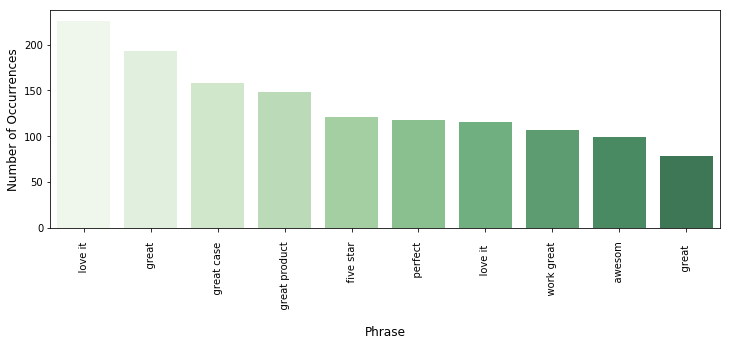

In [15]:
pos_pro_0 = pos_data_2['stem_text'].value_counts()
pos_pro = pos_pro_0[:10]
plt.figure(figsize=(12,4))
sns.barplot(pos_pro.index, pos_pro.values, alpha=0.8, palette = "Greens")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Phrase', fontsize=12)
plt.xticks(rotation=90)
plt.show();

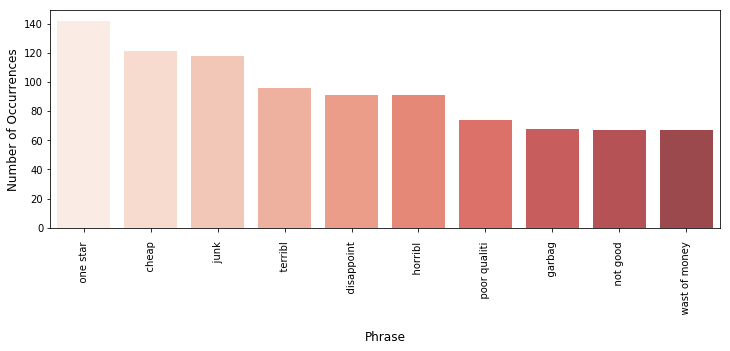

In [16]:
neg_pro_0 = neg_data['stem_text'].value_counts()
neg_pro = neg_pro_0[:10]
plt.figure(figsize=(12,4))
sns.barplot(neg_pro.index, neg_pro.values, alpha=0.8, palette = "Reds")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Phrase', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Looking at the top 10 most summarized comments, it's clear why the above comments were ranked as positive/negative in the given dataset. Phrases seen in the charts are more obviously used to provide positive (e.g. great, awesome, love) or negative (e.g cheap, junk, horrible) sentiments. Given the commonality of these words, I would assume that the above phrases are used for common product reviews, irregardless of product type.

# Basic exploration using Word2Vec

The next couple of lines of code are more for setting up the data for modelling, but the format is also useful for analysis using Word2Vec. Word2vec are estimations of word representations, represented as a vector (it's essentially a two-layer neural network that processes text and outputs vectors). Its useful for the implementation of the continuous bag of words and skip-gram models for computing vector representations of words, with the goal of using these representations for sentiment analysis. As mentioned before, the modelling done later on in this project is relatively simple. In a later implementation of this project, I will work towards developing the aformentioned models. For now, let's review some of the features commonly built using Word2Vec. 

In [17]:
df= pd.concat([pos_data_2, neg_data])
df.head()
pd.value_counts(df['sentiment'])

0    13279
1    13278
Name: sentiment, dtype: int64

In [18]:
df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,text,sentiment,stem_text
0,': 'It would be great if I was a girl....'},0,it would be great if i was a girl
1,': 'Cute but expands'},1,cute but expand
2,': 'Excellent headset. Lasts all day!'},1,excel headset last all day
3,': 'Great Service and Charger'},1,great servic and charger
4,': 'Works perfectly!'},1,work perfect


In [20]:
def labelize_text(text,label):
    result = []
    prefix = label
    for i, t in zip(text.index, text):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x_w2v = labelize_text(df['stem_text'], 'ALL')

C:\Users\pbibra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [21]:
all_x_w2v

[LabeledSentence(words=['it', 'would', 'be', 'great', 'if', 'i', 'was', 'a', 'girl'], tags=['ALL_0']),
 LabeledSentence(words=['cute', 'but', 'expand'], tags=['ALL_1']),
 LabeledSentence(words=['excel', 'headset', 'last', 'all', 'day'], tags=['ALL_2']),
 LabeledSentence(words=['great', 'servic', 'and', 'charger'], tags=['ALL_3']),
 LabeledSentence(words=['work', 'perfect'], tags=['ALL_4']),
 LabeledSentence(words=['clip', 'broke', 'free', 'in', 'onli', '5', 'month'], tags=['ALL_5']),
 LabeledSentence(words=['not', 'a', 'good', 'bluetooth', 'can', 't', 'hear', 'me', 'on', 'the', 'other', 'end', 'static', 'on', 'my', 'end', 'so', 'i', 'have', 'to', 'take', 'it', 'off'], tags=['ALL_6']),
 LabeledSentence(words=['final', 'found', 'it'], tags=['ALL_7']),
 LabeledSentence(words=['rock'], tags=['ALL_8']),
 LabeledSentence(words=['work', 'great'], tags=['ALL_9']),
 LabeledSentence(words=['product', 'did', 'not', 'work'], tags=['ALL_10']),
 LabeledSentence(words=['good', 'charger'], tags=['ALL_

In [22]:
model_w2v = Word2Vec(size=200, min_count=10)
model_w2v.build_vocab([x.words for x in tqdm(all_x_w2v)])
model_w2v.train([x.words for x in tqdm(all_x_w2v)], total_examples=len(all_x_w2v), epochs=1)

100%|██████████| 26557/26557 [00:00<00:00, 2408027.57it/s]


(72670, 115274)

One of the coolest features of Word2Vec, as seen below, is the development of its dictionary and ability to call upon words that appear "similar" to the word in question. From a technical perspective, this method computes a cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model (i.e. almost like a distance calculation between words). 

In [24]:
model_w2v.most_similar(positive=['good', 'great','love'], negative=['bad','junk','cheap'])

C:\Users\pbibra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('awe', 0.09447803348302841),
 ('sweet', 0.07792092859745026),
 ('disapoint', 0.04666804522275925),
 ('regret', 0.040046729147434235),
 ('multi', 0.033992014825344086),
 ('interfer', 0.033637724816799164),
 ('elsewher', 0.0335102342069149),
 ('iii', 0.03339041769504547),
 ('rainbow', 0.03127700835466385),
 ('name', 0.028099698945879936)]

In [24]:
model_w2v.most_similar(positive=['great', 'love'], negative=['bad','junk','cheap'])

C:\Users\pbibra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('boo', -0.04649512469768524),
 ('ador', -0.27974751591682434),
 ('awe', -0.36182355880737305),
 ('fan', -0.5305407643318176),
 ('eh', -0.62938392162323),
 ('luv', -0.6563239097595215),
 ('display', -0.8269129991531372),
 ('disapoint', -0.8351025581359863),
 ('bud', -0.8377053737640381),
 ('speck', -0.842843770980835)]

Given the sheer size of the vocabulary and the inclusion of prepositions, more cleaning is needed to generate better results for the _most similar_ feature, especially in the first result, which looks at words associated more with the words in the positive parameter. Furthermore, though certain words may appear to have a negative connation, words like "dissapoint" in conjunction with "not/never" to create phrases like "never dissapointed" are not present, and can be interpreted as positive. However, the second call produces words negatively associated with the positive parameters, for which some of the words (e.g. boo and dissapoint) are apparent opposites. 

In [25]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

word_vec = [model_w2v[w] for w in list(model_w2v.wv.vocab.keys())[:5000]]

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vec)

tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(model_w2v.wv.vocab.keys())[:5000]

plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)


Loading BokehJS ...

C:\Users\pbibra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 988 samples in 0.012s...
[t-SNE] Computed neighbors for 988 samples in 0.215s...
[t-SNE] Computed conditional probabilities for sample 988 / 988
[t-SNE] Mean sigma: 0.010484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.109413
[t-SNE] KL divergence after 1000 iterations: 0.333797


The above diagram also provides interesting insights, with the goal of providing a visualization of semantically similar words (each point is a word, and the closer a point is to another the more semantically similar the model recognizes it as). Similar to the _most similar_ feature, some words don't actually associate well with each others when applying human logic to the analysis. However, it's intersting to see some of the relationships between words, as recognized by the model (can Zoom in and out to view). "Unreliable" and "joke" are two examples of words that are close to each other, as well as "iphone5" and "unhappy", along with "junk", "price" and "worth". Other close points like "nope" and "winner" have less value semantically. 

# Sentiment Analysis

Especially with reduced textual data (e.g. summary level data), simplified machine learning models can provide strong results vs more complex data models (like the aformentioned continuous bag of words model), which rely more heavily on the sentiments of words. The models below first apply a numerical statistic (in this case, frequency of the word itself) per each row of data (known as TF-IDF vectorization). This numerical representation of words and the sentiments provided in the dataset are fed into the model as the X and Y variables, respectively. 

In [26]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(df.stem_text)
y = np.array(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
predictions = text_classifier.predict(X_test) 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[3323  613]
 [ 601 3431]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      3936
           1       0.85      0.85      0.85      4032

   micro avg       0.85      0.85      0.85      7968
   macro avg       0.85      0.85      0.85      7968
weighted avg       0.85      0.85      0.85      7968

0.847640562248996


In [29]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(7, activation='relu', kernel_initializer='random_normal', input_dim=1361))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [30]:
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [33]:
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
18589/18589 [==============================] - ETA: 11s - loss: 0.1610 - acc: 0.90 - ETA: 2s - loss: 0.2538 - acc: 0.8917 - ETA: 3s - loss: 0.2744 - acc: 0.885 - ETA: 3s - loss: 0.2894 - acc: 0.869 - ETA: 3s - loss: 0.2775 - acc: 0.874 - ETA: 3s - loss: 0.2766 - acc: 0.876 - ETA: 2s - loss: 0.2761 - acc: 0.877 - ETA: 2s - loss: 0.2725 - acc: 0.878 - ETA: 2s - loss: 0.2756 - acc: 0.877 - ETA: 2s - loss: 0.2740 - acc: 0.878 - ETA: 2s - loss: 0.2739 - acc: 0.877 - ETA: 3s - loss: 0.2740 - acc: 0.878 - ETA: 2s - loss: 0.2765 - acc: 0.878 - ETA: 2s - loss: 0.2740 - acc: 0.879 - ETA: 2s - loss: 0.2738 - acc: 0.880 - ETA: 2s - loss: 0.2695 - acc: 0.882 - ETA: 2s - loss: 0.2692 - acc: 0.883 - ETA: 2s - loss: 0.2666 - acc: 0.884 - ETA: 2s - loss: 0.2686 - acc: 0.884 - ETA: 2s - loss: 0.2697 - acc: 0.883 - ETA: 2s - loss: 0.2715 - acc: 0.882 - ETA: 2s - loss: 0.2720 - acc: 0.882 - ETA: 2s - loss: 0.2706 - acc: 0.882 - ETA: 2s - loss: 0.2699 - acc: 0.883 - ETA: 2s - loss: 0.2700 - acc

18589/18589 [==============================] - ETA: 6s - loss: 0.1525 - acc: 0.900 - ETA: 3s - loss: 0.2471 - acc: 0.896 - ETA: 3s - loss: 0.2533 - acc: 0.888 - ETA: 3s - loss: 0.2379 - acc: 0.901 - ETA: 3s - loss: 0.2416 - acc: 0.895 - ETA: 3s - loss: 0.2384 - acc: 0.899 - ETA: 3s - loss: 0.2354 - acc: 0.903 - ETA: 3s - loss: 0.2346 - acc: 0.902 - ETA: 3s - loss: 0.2359 - acc: 0.902 - ETA: 3s - loss: 0.2323 - acc: 0.903 - ETA: 3s - loss: 0.2329 - acc: 0.903 - ETA: 3s - loss: 0.2356 - acc: 0.900 - ETA: 3s - loss: 0.2371 - acc: 0.898 - ETA: 3s - loss: 0.2337 - acc: 0.901 - ETA: 3s - loss: 0.2313 - acc: 0.902 - ETA: 3s - loss: 0.2296 - acc: 0.904 - ETA: 3s - loss: 0.2297 - acc: 0.904 - ETA: 3s - loss: 0.2296 - acc: 0.903 - ETA: 3s - loss: 0.2298 - acc: 0.903 - ETA: 3s - loss: 0.2311 - acc: 0.901 - ETA: 3s - loss: 0.2324 - acc: 0.901 - ETA: 3s - loss: 0.2361 - acc: 0.899 - ETA: 3s - loss: 0.2359 - acc: 0.899 - ETA: 3s - loss: 0.2401 - acc: 0.898 - ETA: 3s - loss: 0.2395 - acc: 0.898 - ETA

18589/18589 [==============================] - ETA: 9s - loss: 0.2143 - acc: 0.800 - ETA: 3s - loss: 0.3325 - acc: 0.861 - ETA: 3s - loss: 0.2875 - acc: 0.863 - ETA: 3s - loss: 0.2758 - acc: 0.868 - ETA: 3s - loss: 0.2639 - acc: 0.877 - ETA: 3s - loss: 0.2754 - acc: 0.873 - ETA: 3s - loss: 0.2859 - acc: 0.866 - ETA: 3s - loss: 0.2780 - acc: 0.871 - ETA: 3s - loss: 0.2759 - acc: 0.872 - ETA: 3s - loss: 0.2786 - acc: 0.871 - ETA: 3s - loss: 0.2749 - acc: 0.873 - ETA: 3s - loss: 0.2708 - acc: 0.875 - ETA: 3s - loss: 0.2717 - acc: 0.875 - ETA: 3s - loss: 0.2691 - acc: 0.876 - ETA: 3s - loss: 0.2712 - acc: 0.875 - ETA: 3s - loss: 0.2697 - acc: 0.876 - ETA: 3s - loss: 0.2669 - acc: 0.878 - ETA: 3s - loss: 0.2674 - acc: 0.878 - ETA: 3s - loss: 0.2684 - acc: 0.878 - ETA: 3s - loss: 0.2669 - acc: 0.879 - ETA: 3s - loss: 0.2675 - acc: 0.878 - ETA: 3s - loss: 0.2663 - acc: 0.880 - ETA: 2s - loss: 0.2667 - acc: 0.880 - ETA: 2s - loss: 0.2659 - acc: 0.880 - ETA: 2s - loss: 0.2641 - acc: 0.882 - ETA

18589/18589 [==============================] - ETA: 7s - loss: 0.1662 - acc: 0.900 - ETA: 4s - loss: 0.2139 - acc: 0.913 - ETA: 4s - loss: 0.2368 - acc: 0.900 - ETA: 4s - loss: 0.2331 - acc: 0.900 - ETA: 4s - loss: 0.2341 - acc: 0.893 - ETA: 4s - loss: 0.2342 - acc: 0.892 - ETA: 3s - loss: 0.2352 - acc: 0.895 - ETA: 3s - loss: 0.2397 - acc: 0.893 - ETA: 3s - loss: 0.2444 - acc: 0.893 - ETA: 3s - loss: 0.2495 - acc: 0.893 - ETA: 3s - loss: 0.2526 - acc: 0.890 - ETA: 3s - loss: 0.2574 - acc: 0.888 - ETA: 2s - loss: 0.2557 - acc: 0.891 - ETA: 2s - loss: 0.2557 - acc: 0.892 - ETA: 2s - loss: 0.2562 - acc: 0.892 - ETA: 2s - loss: 0.2627 - acc: 0.888 - ETA: 2s - loss: 0.2596 - acc: 0.890 - ETA: 2s - loss: 0.2598 - acc: 0.890 - ETA: 2s - loss: 0.2607 - acc: 0.889 - ETA: 2s - loss: 0.2604 - acc: 0.889 - ETA: 2s - loss: 0.2599 - acc: 0.889 - ETA: 2s - loss: 0.2613 - acc: 0.889 - ETA: 2s - loss: 0.2626 - acc: 0.888 - ETA: 2s - loss: 0.2626 - acc: 0.889 - ETA: 2s - loss: 0.2649 - acc: 0.887 - ETA

18589/18589 [==============================] - ETA: 11s - loss: 0.4213 - acc: 0.80 - ETA: 4s - loss: 0.2917 - acc: 0.8609 - ETA: 4s - loss: 0.3016 - acc: 0.861 - ETA: 4s - loss: 0.2670 - acc: 0.883 - ETA: 4s - loss: 0.2786 - acc: 0.876 - ETA: 4s - loss: 0.2628 - acc: 0.886 - ETA: 4s - loss: 0.2664 - acc: 0.884 - ETA: 4s - loss: 0.2582 - acc: 0.887 - ETA: 4s - loss: 0.2556 - acc: 0.887 - ETA: 4s - loss: 0.2512 - acc: 0.889 - ETA: 4s - loss: 0.2507 - acc: 0.890 - ETA: 4s - loss: 0.2544 - acc: 0.888 - ETA: 4s - loss: 0.2586 - acc: 0.887 - ETA: 4s - loss: 0.2581 - acc: 0.886 - ETA: 4s - loss: 0.2614 - acc: 0.883 - ETA: 4s - loss: 0.2590 - acc: 0.883 - ETA: 4s - loss: 0.2597 - acc: 0.882 - ETA: 4s - loss: 0.2565 - acc: 0.883 - ETA: 3s - loss: 0.2562 - acc: 0.884 - ETA: 3s - loss: 0.2575 - acc: 0.883 - ETA: 3s - loss: 0.2611 - acc: 0.881 - ETA: 3s - loss: 0.2622 - acc: 0.880 - ETA: 3s - loss: 0.2580 - acc: 0.882 - ETA: 3s - loss: 0.2572 - acc: 0.882 - ETA: 3s - loss: 0.2568 - acc: 0.883 - ET

18589/18589 [==============================] - ETA: 8s - loss: 0.3422 - acc: 0.800 - ETA: 4s - loss: 0.2955 - acc: 0.854 - ETA: 4s - loss: 0.2411 - acc: 0.885 - ETA: 4s - loss: 0.2570 - acc: 0.869 - ETA: 3s - loss: 0.2470 - acc: 0.875 - ETA: 3s - loss: 0.2488 - acc: 0.876 - ETA: 3s - loss: 0.2453 - acc: 0.879 - ETA: 3s - loss: 0.2494 - acc: 0.877 - ETA: 3s - loss: 0.2530 - acc: 0.878 - ETA: 3s - loss: 0.2564 - acc: 0.882 - ETA: 3s - loss: 0.2563 - acc: 0.881 - ETA: 3s - loss: 0.2530 - acc: 0.884 - ETA: 2s - loss: 0.2543 - acc: 0.885 - ETA: 2s - loss: 0.2559 - acc: 0.884 - ETA: 2s - loss: 0.2584 - acc: 0.883 - ETA: 2s - loss: 0.2548 - acc: 0.885 - ETA: 2s - loss: 0.2557 - acc: 0.883 - ETA: 2s - loss: 0.2592 - acc: 0.882 - ETA: 2s - loss: 0.2562 - acc: 0.884 - ETA: 2s - loss: 0.2562 - acc: 0.883 - ETA: 2s - loss: 0.2592 - acc: 0.882 - ETA: 2s - loss: 0.2585 - acc: 0.882 - ETA: 2s - loss: 0.2589 - acc: 0.882 - ETA: 2s - loss: 0.2577 - acc: 0.882 - ETA: 2s - loss: 0.2577 - acc: 0.883 - ETA

18589/18589 [==============================] - ETA: 9s - loss: 0.8548 - acc: 0.600 - ETA: 3s - loss: 0.2650 - acc: 0.896 - ETA: 3s - loss: 0.2278 - acc: 0.910 - ETA: 3s - loss: 0.2302 - acc: 0.904 - ETA: 3s - loss: 0.2174 - acc: 0.912 - ETA: 3s - loss: 0.2342 - acc: 0.902 - ETA: 2s - loss: 0.2358 - acc: 0.899 - ETA: 2s - loss: 0.2394 - acc: 0.896 - ETA: 2s - loss: 0.2432 - acc: 0.894 - ETA: 2s - loss: 0.2503 - acc: 0.891 - ETA: 2s - loss: 0.2480 - acc: 0.892 - ETA: 2s - loss: 0.2438 - acc: 0.895 - ETA: 2s - loss: 0.2462 - acc: 0.894 - ETA: 2s - loss: 0.2451 - acc: 0.895 - ETA: 2s - loss: 0.2461 - acc: 0.893 - ETA: 2s - loss: 0.2478 - acc: 0.892 - ETA: 2s - loss: 0.2437 - acc: 0.893 - ETA: 2s - loss: 0.2450 - acc: 0.893 - ETA: 2s - loss: 0.2489 - acc: 0.890 - ETA: 2s - loss: 0.2501 - acc: 0.889 - ETA: 2s - loss: 0.2498 - acc: 0.890 - ETA: 2s - loss: 0.2488 - acc: 0.890 - ETA: 2s - loss: 0.2483 - acc: 0.890 - ETA: 2s - loss: 0.2483 - acc: 0.890 - ETA: 2s - loss: 0.2473 - acc: 0.890 - ETA

18589/18589 [==============================] - ETA: 17s - loss: 0.2607 - acc: 0.80 - ETA: 5s - loss: 0.2287 - acc: 0.9105 - ETA: 5s - loss: 0.2408 - acc: 0.897 - ETA: 4s - loss: 0.2614 - acc: 0.885 - ETA: 4s - loss: 0.2620 - acc: 0.881 - ETA: 4s - loss: 0.2691 - acc: 0.879 - ETA: 3s - loss: 0.2662 - acc: 0.879 - ETA: 3s - loss: 0.2677 - acc: 0.882 - ETA: 3s - loss: 0.2618 - acc: 0.884 - ETA: 3s - loss: 0.2539 - acc: 0.888 - ETA: 3s - loss: 0.2572 - acc: 0.886 - ETA: 3s - loss: 0.2551 - acc: 0.887 - ETA: 3s - loss: 0.2509 - acc: 0.888 - ETA: 3s - loss: 0.2497 - acc: 0.890 - ETA: 3s - loss: 0.2507 - acc: 0.889 - ETA: 3s - loss: 0.2515 - acc: 0.889 - ETA: 2s - loss: 0.2528 - acc: 0.889 - ETA: 2s - loss: 0.2534 - acc: 0.888 - ETA: 2s - loss: 0.2562 - acc: 0.888 - ETA: 2s - loss: 0.2546 - acc: 0.890 - ETA: 2s - loss: 0.2553 - acc: 0.889 - ETA: 2s - loss: 0.2553 - acc: 0.889 - ETA: 2s - loss: 0.2533 - acc: 0.889 - ETA: 2s - loss: 0.2545 - acc: 0.889 - ETA: 2s - loss: 0.2559 - acc: 0.888 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.3361 - acc: 0.80 - ETA: 3s - loss: 0.2341 - acc: 0.9000 - ETA: 3s - loss: 0.2316 - acc: 0.893 - ETA: 3s - loss: 0.2213 - acc: 0.897 - ETA: 3s - loss: 0.2149 - acc: 0.900 - ETA: 2s - loss: 0.2187 - acc: 0.902 - ETA: 2s - loss: 0.2163 - acc: 0.905 - ETA: 2s - loss: 0.2194 - acc: 0.902 - ETA: 2s - loss: 0.2235 - acc: 0.900 - ETA: 2s - loss: 0.2230 - acc: 0.899 - ETA: 2s - loss: 0.2199 - acc: 0.901 - ETA: 2s - loss: 0.2236 - acc: 0.900 - ETA: 2s - loss: 0.2261 - acc: 0.899 - ETA: 3s - loss: 0.2277 - acc: 0.897 - ETA: 3s - loss: 0.2265 - acc: 0.899 - ETA: 3s - loss: 0.2275 - acc: 0.898 - ETA: 3s - loss: 0.2299 - acc: 0.896 - ETA: 3s - loss: 0.2311 - acc: 0.895 - ETA: 3s - loss: 0.2323 - acc: 0.894 - ETA: 3s - loss: 0.2317 - acc: 0.895 - ETA: 3s - loss: 0.2300 - acc: 0.897 - ETA: 3s - loss: 0.2332 - acc: 0.896 - ETA: 3s - loss: 0.2337 - acc: 0.896 - ETA: 3s - loss: 0.2365 - acc: 0.895 - ETA: 2s - loss: 0.2401 - acc: 0.892 - ET

18589/18589 [==============================] - ETA: 8s - loss: 0.3076 - acc: 0.900 - ETA: 2s - loss: 0.2755 - acc: 0.880 - ETA: 2s - loss: 0.2450 - acc: 0.897 - ETA: 2s - loss: 0.2669 - acc: 0.887 - ETA: 2s - loss: 0.2493 - acc: 0.895 - ETA: 2s - loss: 0.2425 - acc: 0.894 - ETA: 2s - loss: 0.2512 - acc: 0.889 - ETA: 2s - loss: 0.2590 - acc: 0.887 - ETA: 2s - loss: 0.2569 - acc: 0.887 - ETA: 2s - loss: 0.2543 - acc: 0.887 - ETA: 2s - loss: 0.2525 - acc: 0.887 - ETA: 2s - loss: 0.2505 - acc: 0.889 - ETA: 2s - loss: 0.2500 - acc: 0.889 - ETA: 2s - loss: 0.2505 - acc: 0.888 - ETA: 2s - loss: 0.2484 - acc: 0.890 - ETA: 2s - loss: 0.2469 - acc: 0.890 - ETA: 1s - loss: 0.2476 - acc: 0.889 - ETA: 1s - loss: 0.2493 - acc: 0.889 - ETA: 1s - loss: 0.2503 - acc: 0.888 - ETA: 2s - loss: 0.2500 - acc: 0.889 - ETA: 1s - loss: 0.2503 - acc: 0.889 - ETA: 1s - loss: 0.2497 - acc: 0.890 - ETA: 1s - loss: 0.2502 - acc: 0.889 - ETA: 1s - loss: 0.2500 - acc: 0.889 - ETA: 1s - loss: 0.2490 - acc: 0.890 - ETA

Epoch 24/100
18589/18589 [==============================] - ETA: 7s - loss: 0.2908 - acc: 0.900 - ETA: 3s - loss: 0.1941 - acc: 0.921 - ETA: 2s - loss: 0.2016 - acc: 0.909 - ETA: 2s - loss: 0.2135 - acc: 0.903 - ETA: 2s - loss: 0.2158 - acc: 0.903 - ETA: 2s - loss: 0.2278 - acc: 0.898 - ETA: 2s - loss: 0.2368 - acc: 0.893 - ETA: 2s - loss: 0.2392 - acc: 0.891 - ETA: 2s - loss: 0.2391 - acc: 0.891 - ETA: 2s - loss: 0.2419 - acc: 0.889 - ETA: 2s - loss: 0.2399 - acc: 0.890 - ETA: 2s - loss: 0.2381 - acc: 0.892 - ETA: 2s - loss: 0.2396 - acc: 0.891 - ETA: 2s - loss: 0.2381 - acc: 0.892 - ETA: 2s - loss: 0.2362 - acc: 0.894 - ETA: 2s - loss: 0.2365 - acc: 0.894 - ETA: 2s - loss: 0.2364 - acc: 0.895 - ETA: 2s - loss: 0.2389 - acc: 0.893 - ETA: 2s - loss: 0.2382 - acc: 0.893 - ETA: 2s - loss: 0.2376 - acc: 0.893 - ETA: 1s - loss: 0.2389 - acc: 0.893 - ETA: 1s - loss: 0.2392 - acc: 0.892 - ETA: 1s - loss: 0.2396 - acc: 0.891 - ETA: 1s - loss: 0.2429 - acc: 0.890 - ETA: 1s - loss: 0.2442 - acc

18589/18589 [==============================] - ETA: 8s - loss: 0.3124 - acc: 0.900 - ETA: 8s - loss: 0.2585 - acc: 0.900 - ETA: 6s - loss: 0.2321 - acc: 0.893 - ETA: 8s - loss: 0.2192 - acc: 0.900 - ETA: 9s - loss: 0.2090 - acc: 0.907 - ETA: 10s - loss: 0.2112 - acc: 0.90 - ETA: 11s - loss: 0.2054 - acc: 0.91 - ETA: 11s - loss: 0.2112 - acc: 0.90 - ETA: 10s - loss: 0.2098 - acc: 0.90 - ETA: 11s - loss: 0.2132 - acc: 0.90 - ETA: 9s - loss: 0.2179 - acc: 0.9030 - ETA: 8s - loss: 0.2261 - acc: 0.900 - ETA: 8s - loss: 0.2284 - acc: 0.897 - ETA: 9s - loss: 0.2295 - acc: 0.897 - ETA: 8s - loss: 0.2326 - acc: 0.897 - ETA: 8s - loss: 0.2380 - acc: 0.895 - ETA: 8s - loss: 0.2387 - acc: 0.895 - ETA: 8s - loss: 0.2374 - acc: 0.895 - ETA: 8s - loss: 0.2362 - acc: 0.897 - ETA: 7s - loss: 0.2395 - acc: 0.895 - ETA: 7s - loss: 0.2424 - acc: 0.893 - ETA: 7s - loss: 0.2428 - acc: 0.893 - ETA: 7s - loss: 0.2417 - acc: 0.892 - ETA: 7s - loss: 0.2391 - acc: 0.894 - ETA: 7s - loss: 0.2382 - acc: 0.895 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.1567 - acc: 0.90 - ETA: 5s - loss: 0.2303 - acc: 0.8950 - ETA: 5s - loss: 0.2409 - acc: 0.886 - ETA: 5s - loss: 0.2322 - acc: 0.886 - ETA: 5s - loss: 0.2187 - acc: 0.892 - ETA: 5s - loss: 0.2227 - acc: 0.894 - ETA: 5s - loss: 0.2395 - acc: 0.886 - ETA: 5s - loss: 0.2436 - acc: 0.885 - ETA: 5s - loss: 0.2443 - acc: 0.886 - ETA: 5s - loss: 0.2430 - acc: 0.887 - ETA: 5s - loss: 0.2463 - acc: 0.886 - ETA: 5s - loss: 0.2437 - acc: 0.887 - ETA: 5s - loss: 0.2442 - acc: 0.887 - ETA: 5s - loss: 0.2409 - acc: 0.889 - ETA: 5s - loss: 0.2403 - acc: 0.889 - ETA: 5s - loss: 0.2402 - acc: 0.888 - ETA: 4s - loss: 0.2381 - acc: 0.890 - ETA: 4s - loss: 0.2356 - acc: 0.892 - ETA: 4s - loss: 0.2345 - acc: 0.893 - ETA: 4s - loss: 0.2312 - acc: 0.895 - ETA: 4s - loss: 0.2309 - acc: 0.896 - ETA: 4s - loss: 0.2322 - acc: 0.895 - ETA: 4s - loss: 0.2343 - acc: 0.894 - ETA: 4s - loss: 0.2370 - acc: 0.894 - ETA: 4s - loss: 0.2355 - acc: 0.894 - ET

18589/18589 [==============================] - ETA: 9s - loss: 0.1558 - acc: 0.900 - ETA: 9s - loss: 0.1949 - acc: 0.931 - ETA: 7s - loss: 0.2098 - acc: 0.915 - ETA: 6s - loss: 0.2274 - acc: 0.904 - ETA: 6s - loss: 0.2370 - acc: 0.900 - ETA: 6s - loss: 0.2266 - acc: 0.903 - ETA: 6s - loss: 0.2245 - acc: 0.903 - ETA: 6s - loss: 0.2287 - acc: 0.899 - ETA: 5s - loss: 0.2325 - acc: 0.896 - ETA: 5s - loss: 0.2294 - acc: 0.898 - ETA: 5s - loss: 0.2262 - acc: 0.901 - ETA: 5s - loss: 0.2287 - acc: 0.901 - ETA: 5s - loss: 0.2311 - acc: 0.900 - ETA: 5s - loss: 0.2304 - acc: 0.901 - ETA: 5s - loss: 0.2281 - acc: 0.902 - ETA: 5s - loss: 0.2268 - acc: 0.903 - ETA: 5s - loss: 0.2279 - acc: 0.903 - ETA: 5s - loss: 0.2294 - acc: 0.903 - ETA: 5s - loss: 0.2287 - acc: 0.904 - ETA: 5s - loss: 0.2279 - acc: 0.903 - ETA: 5s - loss: 0.2289 - acc: 0.902 - ETA: 5s - loss: 0.2258 - acc: 0.904 - ETA: 5s - loss: 0.2261 - acc: 0.904 - ETA: 5s - loss: 0.2261 - acc: 0.903 - ETA: 5s - loss: 0.2256 - acc: 0.904 - ETA

18589/18589 [==============================] - ETA: 13s - loss: 0.2858 - acc: 0.80 - ETA: 5s - loss: 0.2301 - acc: 0.8947 - ETA: 5s - loss: 0.2464 - acc: 0.883 - ETA: 5s - loss: 0.2295 - acc: 0.896 - ETA: 5s - loss: 0.2397 - acc: 0.892 - ETA: 5s - loss: 0.2380 - acc: 0.889 - ETA: 5s - loss: 0.2329 - acc: 0.895 - ETA: 5s - loss: 0.2446 - acc: 0.891 - ETA: 5s - loss: 0.2402 - acc: 0.895 - ETA: 5s - loss: 0.2388 - acc: 0.898 - ETA: 5s - loss: 0.2369 - acc: 0.897 - ETA: 5s - loss: 0.2337 - acc: 0.898 - ETA: 4s - loss: 0.2313 - acc: 0.901 - ETA: 4s - loss: 0.2284 - acc: 0.902 - ETA: 4s - loss: 0.2299 - acc: 0.899 - ETA: 4s - loss: 0.2283 - acc: 0.900 - ETA: 4s - loss: 0.2265 - acc: 0.901 - ETA: 4s - loss: 0.2277 - acc: 0.898 - ETA: 4s - loss: 0.2327 - acc: 0.895 - ETA: 4s - loss: 0.2315 - acc: 0.897 - ETA: 4s - loss: 0.2330 - acc: 0.895 - ETA: 4s - loss: 0.2336 - acc: 0.895 - ETA: 4s - loss: 0.2327 - acc: 0.895 - ETA: 4s - loss: 0.2309 - acc: 0.896 - ETA: 4s - loss: 0.2321 - acc: 0.896 - ET

18589/18589 [==============================] - ETA: 10s - loss: 0.2426 - acc: 0.90 - ETA: 6s - loss: 0.2861 - acc: 0.8438 - ETA: 6s - loss: 0.2843 - acc: 0.856 - ETA: 6s - loss: 0.2783 - acc: 0.870 - ETA: 5s - loss: 0.2720 - acc: 0.871 - ETA: 5s - loss: 0.2606 - acc: 0.875 - ETA: 5s - loss: 0.2589 - acc: 0.874 - ETA: 5s - loss: 0.2545 - acc: 0.875 - ETA: 5s - loss: 0.2601 - acc: 0.873 - ETA: 5s - loss: 0.2588 - acc: 0.878 - ETA: 5s - loss: 0.2541 - acc: 0.882 - ETA: 5s - loss: 0.2561 - acc: 0.881 - ETA: 5s - loss: 0.2509 - acc: 0.886 - ETA: 5s - loss: 0.2549 - acc: 0.883 - ETA: 5s - loss: 0.2497 - acc: 0.886 - ETA: 5s - loss: 0.2486 - acc: 0.887 - ETA: 5s - loss: 0.2482 - acc: 0.886 - ETA: 5s - loss: 0.2506 - acc: 0.885 - ETA: 5s - loss: 0.2500 - acc: 0.887 - ETA: 5s - loss: 0.2487 - acc: 0.887 - ETA: 5s - loss: 0.2486 - acc: 0.888 - ETA: 5s - loss: 0.2457 - acc: 0.889 - ETA: 5s - loss: 0.2432 - acc: 0.890 - ETA: 5s - loss: 0.2414 - acc: 0.891 - ETA: 5s - loss: 0.2393 - acc: 0.892 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.0769 - acc: 1.00 - ETA: 10s - loss: 0.2164 - acc: 0.90 - ETA: 8s - loss: 0.2315 - acc: 0.9040 - ETA: 7s - loss: 0.2382 - acc: 0.892 - ETA: 7s - loss: 0.2471 - acc: 0.886 - ETA: 7s - loss: 0.2520 - acc: 0.883 - ETA: 7s - loss: 0.2513 - acc: 0.886 - ETA: 7s - loss: 0.2451 - acc: 0.889 - ETA: 6s - loss: 0.2475 - acc: 0.886 - ETA: 6s - loss: 0.2517 - acc: 0.886 - ETA: 6s - loss: 0.2497 - acc: 0.887 - ETA: 6s - loss: 0.2464 - acc: 0.891 - ETA: 6s - loss: 0.2484 - acc: 0.889 - ETA: 6s - loss: 0.2525 - acc: 0.887 - ETA: 6s - loss: 0.2521 - acc: 0.888 - ETA: 6s - loss: 0.2542 - acc: 0.888 - ETA: 6s - loss: 0.2519 - acc: 0.887 - ETA: 5s - loss: 0.2515 - acc: 0.887 - ETA: 5s - loss: 0.2486 - acc: 0.889 - ETA: 5s - loss: 0.2452 - acc: 0.891 - ETA: 5s - loss: 0.2462 - acc: 0.891 - ETA: 5s - loss: 0.2450 - acc: 0.892 - ETA: 5s - loss: 0.2425 - acc: 0.893 - ETA: 5s - loss: 0.2419 - acc: 0.892 - ETA: 5s - loss: 0.2430 - acc: 0.891 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.1337 - acc: 0.90 - ETA: 5s - loss: 0.1547 - acc: 0.9474 - ETA: 5s - loss: 0.1839 - acc: 0.928 - ETA: 5s - loss: 0.1894 - acc: 0.927 - ETA: 5s - loss: 0.1879 - acc: 0.925 - ETA: 5s - loss: 0.1964 - acc: 0.919 - ETA: 5s - loss: 0.2071 - acc: 0.908 - ETA: 5s - loss: 0.2093 - acc: 0.906 - ETA: 5s - loss: 0.2104 - acc: 0.908 - ETA: 4s - loss: 0.2112 - acc: 0.908 - ETA: 4s - loss: 0.2142 - acc: 0.906 - ETA: 4s - loss: 0.2165 - acc: 0.905 - ETA: 4s - loss: 0.2199 - acc: 0.904 - ETA: 4s - loss: 0.2237 - acc: 0.902 - ETA: 4s - loss: 0.2218 - acc: 0.905 - ETA: 4s - loss: 0.2269 - acc: 0.904 - ETA: 4s - loss: 0.2277 - acc: 0.903 - ETA: 4s - loss: 0.2317 - acc: 0.901 - ETA: 4s - loss: 0.2298 - acc: 0.901 - ETA: 4s - loss: 0.2318 - acc: 0.900 - ETA: 4s - loss: 0.2338 - acc: 0.899 - ETA: 4s - loss: 0.2307 - acc: 0.900 - ETA: 4s - loss: 0.2345 - acc: 0.898 - ETA: 4s - loss: 0.2347 - acc: 0.898 - ETA: 4s - loss: 0.2383 - acc: 0.897 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.1677 - acc: 0.90 - ETA: 6s - loss: 0.2374 - acc: 0.8750 - ETA: 5s - loss: 0.2229 - acc: 0.891 - ETA: 5s - loss: 0.2303 - acc: 0.892 - ETA: 5s - loss: 0.2272 - acc: 0.895 - ETA: 5s - loss: 0.2442 - acc: 0.892 - ETA: 5s - loss: 0.2454 - acc: 0.894 - ETA: 5s - loss: 0.2487 - acc: 0.887 - ETA: 5s - loss: 0.2459 - acc: 0.888 - ETA: 5s - loss: 0.2432 - acc: 0.890 - ETA: 5s - loss: 0.2444 - acc: 0.890 - ETA: 5s - loss: 0.2387 - acc: 0.892 - ETA: 5s - loss: 0.2376 - acc: 0.893 - ETA: 5s - loss: 0.2426 - acc: 0.890 - ETA: 5s - loss: 0.2469 - acc: 0.890 - ETA: 5s - loss: 0.2431 - acc: 0.892 - ETA: 4s - loss: 0.2429 - acc: 0.894 - ETA: 4s - loss: 0.2424 - acc: 0.894 - ETA: 4s - loss: 0.2428 - acc: 0.896 - ETA: 4s - loss: 0.2418 - acc: 0.897 - ETA: 4s - loss: 0.2375 - acc: 0.899 - ETA: 4s - loss: 0.2358 - acc: 0.901 - ETA: 4s - loss: 0.2375 - acc: 0.901 - ETA: 4s - loss: 0.2366 - acc: 0.901 - ETA: 4s - loss: 0.2350 - acc: 0.901 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.0513 - acc: 1.00 - ETA: 6s - loss: 0.2548 - acc: 0.8800 - ETA: 6s - loss: 0.2406 - acc: 0.886 - ETA: 6s - loss: 0.2319 - acc: 0.893 - ETA: 6s - loss: 0.2174 - acc: 0.904 - ETA: 5s - loss: 0.2098 - acc: 0.912 - ETA: 5s - loss: 0.2143 - acc: 0.907 - ETA: 5s - loss: 0.2156 - acc: 0.905 - ETA: 5s - loss: 0.2247 - acc: 0.900 - ETA: 5s - loss: 0.2306 - acc: 0.900 - ETA: 5s - loss: 0.2270 - acc: 0.901 - ETA: 5s - loss: 0.2208 - acc: 0.904 - ETA: 5s - loss: 0.2256 - acc: 0.901 - ETA: 5s - loss: 0.2291 - acc: 0.898 - ETA: 5s - loss: 0.2277 - acc: 0.898 - ETA: 5s - loss: 0.2289 - acc: 0.899 - ETA: 5s - loss: 0.2313 - acc: 0.897 - ETA: 5s - loss: 0.2331 - acc: 0.898 - ETA: 5s - loss: 0.2329 - acc: 0.898 - ETA: 5s - loss: 0.2345 - acc: 0.895 - ETA: 5s - loss: 0.2333 - acc: 0.898 - ETA: 5s - loss: 0.2332 - acc: 0.897 - ETA: 5s - loss: 0.2303 - acc: 0.899 - ETA: 5s - loss: 0.2275 - acc: 0.901 - ETA: 5s - loss: 0.2274 - acc: 0.901 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.1875 - acc: 0.90 - ETA: 7s - loss: 0.2288 - acc: 0.9062 - ETA: 7s - loss: 0.2225 - acc: 0.914 - ETA: 7s - loss: 0.2371 - acc: 0.900 - ETA: 6s - loss: 0.2273 - acc: 0.905 - ETA: 6s - loss: 0.2329 - acc: 0.900 - ETA: 6s - loss: 0.2234 - acc: 0.907 - ETA: 6s - loss: 0.2308 - acc: 0.904 - ETA: 6s - loss: 0.2290 - acc: 0.902 - ETA: 6s - loss: 0.2271 - acc: 0.903 - ETA: 6s - loss: 0.2266 - acc: 0.902 - ETA: 5s - loss: 0.2220 - acc: 0.905 - ETA: 5s - loss: 0.2273 - acc: 0.903 - ETA: 5s - loss: 0.2259 - acc: 0.904 - ETA: 5s - loss: 0.2235 - acc: 0.907 - ETA: 5s - loss: 0.2204 - acc: 0.908 - ETA: 5s - loss: 0.2186 - acc: 0.909 - ETA: 5s - loss: 0.2215 - acc: 0.907 - ETA: 5s - loss: 0.2222 - acc: 0.907 - ETA: 5s - loss: 0.2257 - acc: 0.905 - ETA: 5s - loss: 0.2244 - acc: 0.905 - ETA: 5s - loss: 0.2248 - acc: 0.905 - ETA: 5s - loss: 0.2264 - acc: 0.905 - ETA: 5s - loss: 0.2262 - acc: 0.905 - ETA: 5s - loss: 0.2306 - acc: 0.904 - ET

18589/18589 [==============================] - ETA: 15s - loss: 0.4749 - acc: 0.70 - ETA: 7s - loss: 0.3152 - acc: 0.8600 - ETA: 7s - loss: 0.2536 - acc: 0.900 - ETA: 7s - loss: 0.2322 - acc: 0.905 - ETA: 7s - loss: 0.2367 - acc: 0.903 - ETA: 7s - loss: 0.2403 - acc: 0.900 - ETA: 7s - loss: 0.2497 - acc: 0.894 - ETA: 7s - loss: 0.2424 - acc: 0.895 - ETA: 6s - loss: 0.2406 - acc: 0.896 - ETA: 6s - loss: 0.2418 - acc: 0.897 - ETA: 6s - loss: 0.2398 - acc: 0.898 - ETA: 6s - loss: 0.2364 - acc: 0.900 - ETA: 6s - loss: 0.2334 - acc: 0.902 - ETA: 6s - loss: 0.2293 - acc: 0.902 - ETA: 6s - loss: 0.2288 - acc: 0.903 - ETA: 6s - loss: 0.2307 - acc: 0.902 - ETA: 6s - loss: 0.2306 - acc: 0.899 - ETA: 6s - loss: 0.2299 - acc: 0.900 - ETA: 6s - loss: 0.2298 - acc: 0.901 - ETA: 6s - loss: 0.2277 - acc: 0.903 - ETA: 6s - loss: 0.2312 - acc: 0.903 - ETA: 6s - loss: 0.2297 - acc: 0.904 - ETA: 6s - loss: 0.2287 - acc: 0.905 - ETA: 6s - loss: 0.2268 - acc: 0.905 - ETA: 5s - loss: 0.2277 - acc: 0.904 - ET

18589/18589 [==============================] - ETA: 15s - loss: 0.2775 - acc: 0.80 - ETA: 5s - loss: 0.2501 - acc: 0.8947 - ETA: 6s - loss: 0.2313 - acc: 0.903 - ETA: 7s - loss: 0.2218 - acc: 0.902 - ETA: 7s - loss: 0.2218 - acc: 0.903 - ETA: 6s - loss: 0.2283 - acc: 0.904 - ETA: 6s - loss: 0.2439 - acc: 0.893 - ETA: 6s - loss: 0.2517 - acc: 0.887 - ETA: 5s - loss: 0.2497 - acc: 0.888 - ETA: 5s - loss: 0.2401 - acc: 0.893 - ETA: 5s - loss: 0.2370 - acc: 0.898 - ETA: 5s - loss: 0.2338 - acc: 0.900 - ETA: 5s - loss: 0.2317 - acc: 0.900 - ETA: 5s - loss: 0.2349 - acc: 0.900 - ETA: 5s - loss: 0.2384 - acc: 0.897 - ETA: 5s - loss: 0.2396 - acc: 0.895 - ETA: 5s - loss: 0.2392 - acc: 0.894 - ETA: 5s - loss: 0.2405 - acc: 0.892 - ETA: 4s - loss: 0.2403 - acc: 0.892 - ETA: 4s - loss: 0.2434 - acc: 0.892 - ETA: 5s - loss: 0.2432 - acc: 0.892 - ETA: 4s - loss: 0.2404 - acc: 0.893 - ETA: 4s - loss: 0.2391 - acc: 0.894 - ETA: 4s - loss: 0.2412 - acc: 0.892 - ETA: 4s - loss: 0.2417 - acc: 0.892 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.3397 - acc: 0.90 - ETA: 6s - loss: 0.2326 - acc: 0.8875 - ETA: 6s - loss: 0.2345 - acc: 0.896 - ETA: 5s - loss: 0.2273 - acc: 0.904 - ETA: 5s - loss: 0.2460 - acc: 0.892 - ETA: 5s - loss: 0.2339 - acc: 0.894 - ETA: 5s - loss: 0.2429 - acc: 0.894 - ETA: 5s - loss: 0.2370 - acc: 0.900 - ETA: 5s - loss: 0.2325 - acc: 0.903 - ETA: 5s - loss: 0.2348 - acc: 0.904 - ETA: 5s - loss: 0.2396 - acc: 0.901 - ETA: 5s - loss: 0.2414 - acc: 0.901 - ETA: 5s - loss: 0.2453 - acc: 0.898 - ETA: 5s - loss: 0.2442 - acc: 0.897 - ETA: 5s - loss: 0.2459 - acc: 0.896 - ETA: 5s - loss: 0.2451 - acc: 0.896 - ETA: 5s - loss: 0.2422 - acc: 0.898 - ETA: 5s - loss: 0.2439 - acc: 0.897 - ETA: 5s - loss: 0.2429 - acc: 0.899 - ETA: 5s - loss: 0.2409 - acc: 0.899 - ETA: 4s - loss: 0.2393 - acc: 0.900 - ETA: 4s - loss: 0.2415 - acc: 0.900 - ETA: 4s - loss: 0.2430 - acc: 0.898 - ETA: 4s - loss: 0.2426 - acc: 0.898 - ETA: 4s - loss: 0.2429 - acc: 0.898 - ET

18589/18589 [==============================] - ETA: 16s - loss: 0.3424 - acc: 0.90 - ETA: 6s - loss: 0.1994 - acc: 0.9118 - ETA: 6s - loss: 0.2240 - acc: 0.900 - ETA: 6s - loss: 0.2345 - acc: 0.893 - ETA: 6s - loss: 0.2237 - acc: 0.903 - ETA: 6s - loss: 0.2236 - acc: 0.901 - ETA: 5s - loss: 0.2156 - acc: 0.902 - ETA: 5s - loss: 0.2138 - acc: 0.901 - ETA: 5s - loss: 0.2150 - acc: 0.904 - ETA: 5s - loss: 0.2116 - acc: 0.904 - ETA: 5s - loss: 0.2174 - acc: 0.901 - ETA: 5s - loss: 0.2181 - acc: 0.900 - ETA: 5s - loss: 0.2199 - acc: 0.900 - ETA: 5s - loss: 0.2179 - acc: 0.903 - ETA: 5s - loss: 0.2185 - acc: 0.902 - ETA: 5s - loss: 0.2177 - acc: 0.902 - ETA: 5s - loss: 0.2169 - acc: 0.902 - ETA: 5s - loss: 0.2183 - acc: 0.902 - ETA: 5s - loss: 0.2219 - acc: 0.901 - ETA: 5s - loss: 0.2312 - acc: 0.897 - ETA: 5s - loss: 0.2320 - acc: 0.897 - ETA: 5s - loss: 0.2353 - acc: 0.896 - ETA: 5s - loss: 0.2324 - acc: 0.898 - ETA: 5s - loss: 0.2333 - acc: 0.900 - ETA: 5s - loss: 0.2332 - acc: 0.900 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1863 - acc: 0.90 - ETA: 5s - loss: 0.2314 - acc: 0.9000 - ETA: 5s - loss: 0.1954 - acc: 0.917 - ETA: 5s - loss: 0.2179 - acc: 0.901 - ETA: 5s - loss: 0.2253 - acc: 0.905 - ETA: 5s - loss: 0.2405 - acc: 0.896 - ETA: 5s - loss: 0.2327 - acc: 0.901 - ETA: 5s - loss: 0.2304 - acc: 0.903 - ETA: 5s - loss: 0.2307 - acc: 0.903 - ETA: 4s - loss: 0.2439 - acc: 0.895 - ETA: 5s - loss: 0.2416 - acc: 0.896 - ETA: 5s - loss: 0.2419 - acc: 0.894 - ETA: 4s - loss: 0.2417 - acc: 0.893 - ETA: 4s - loss: 0.2375 - acc: 0.895 - ETA: 4s - loss: 0.2381 - acc: 0.896 - ETA: 4s - loss: 0.2356 - acc: 0.898 - ETA: 4s - loss: 0.2357 - acc: 0.897 - ETA: 4s - loss: 0.2340 - acc: 0.897 - ETA: 4s - loss: 0.2313 - acc: 0.899 - ETA: 4s - loss: 0.2324 - acc: 0.899 - ETA: 4s - loss: 0.2350 - acc: 0.898 - ETA: 4s - loss: 0.2350 - acc: 0.898 - ETA: 4s - loss: 0.2328 - acc: 0.899 - ETA: 4s - loss: 0.2320 - acc: 0.900 - ETA: 4s - loss: 0.2326 - acc: 0.899 - ET

18589/18589 [==============================] - ETA: 9s - loss: 0.0824 - acc: 1.000 - ETA: 8s - loss: 0.2317 - acc: 0.933 - ETA: 7s - loss: 0.2262 - acc: 0.928 - ETA: 7s - loss: 0.2212 - acc: 0.918 - ETA: 8s - loss: 0.2379 - acc: 0.902 - ETA: 7s - loss: 0.2410 - acc: 0.898 - ETA: 7s - loss: 0.2419 - acc: 0.901 - ETA: 7s - loss: 0.2417 - acc: 0.901 - ETA: 7s - loss: 0.2370 - acc: 0.901 - ETA: 7s - loss: 0.2427 - acc: 0.897 - ETA: 7s - loss: 0.2393 - acc: 0.899 - ETA: 7s - loss: 0.2421 - acc: 0.900 - ETA: 7s - loss: 0.2402 - acc: 0.900 - ETA: 7s - loss: 0.2439 - acc: 0.898 - ETA: 7s - loss: 0.2402 - acc: 0.901 - ETA: 7s - loss: 0.2370 - acc: 0.902 - ETA: 7s - loss: 0.2412 - acc: 0.901 - ETA: 7s - loss: 0.2396 - acc: 0.902 - ETA: 7s - loss: 0.2394 - acc: 0.902 - ETA: 7s - loss: 0.2374 - acc: 0.902 - ETA: 7s - loss: 0.2383 - acc: 0.901 - ETA: 7s - loss: 0.2397 - acc: 0.900 - ETA: 7s - loss: 0.2378 - acc: 0.901 - ETA: 7s - loss: 0.2391 - acc: 0.899 - ETA: 6s - loss: 0.2409 - acc: 0.899 - ETA

18589/18589 [==============================] - ETA: 9s - loss: 0.3677 - acc: 0.900 - ETA: 7s - loss: 0.2390 - acc: 0.892 - ETA: 7s - loss: 0.2494 - acc: 0.900 - ETA: 7s - loss: 0.2228 - acc: 0.910 - ETA: 7s - loss: 0.2213 - acc: 0.910 - ETA: 6s - loss: 0.2190 - acc: 0.911 - ETA: 6s - loss: 0.2180 - acc: 0.911 - ETA: 6s - loss: 0.2289 - acc: 0.904 - ETA: 6s - loss: 0.2264 - acc: 0.904 - ETA: 6s - loss: 0.2232 - acc: 0.907 - ETA: 6s - loss: 0.2197 - acc: 0.908 - ETA: 6s - loss: 0.2250 - acc: 0.905 - ETA: 6s - loss: 0.2241 - acc: 0.905 - ETA: 6s - loss: 0.2220 - acc: 0.906 - ETA: 6s - loss: 0.2201 - acc: 0.906 - ETA: 5s - loss: 0.2213 - acc: 0.906 - ETA: 5s - loss: 0.2222 - acc: 0.906 - ETA: 5s - loss: 0.2197 - acc: 0.907 - ETA: 5s - loss: 0.2181 - acc: 0.907 - ETA: 5s - loss: 0.2137 - acc: 0.909 - ETA: 5s - loss: 0.2122 - acc: 0.909 - ETA: 5s - loss: 0.2140 - acc: 0.908 - ETA: 5s - loss: 0.2156 - acc: 0.907 - ETA: 5s - loss: 0.2157 - acc: 0.907 - ETA: 5s - loss: 0.2137 - acc: 0.908 - ETA

18589/18589 [==============================] - ETA: 12s - loss: 0.1200 - acc: 1.00 - ETA: 6s - loss: 0.2611 - acc: 0.8875 - ETA: 7s - loss: 0.2447 - acc: 0.903 - ETA: 7s - loss: 0.2460 - acc: 0.904 - ETA: 6s - loss: 0.2475 - acc: 0.900 - ETA: 6s - loss: 0.2452 - acc: 0.898 - ETA: 6s - loss: 0.2417 - acc: 0.895 - ETA: 6s - loss: 0.2314 - acc: 0.901 - ETA: 6s - loss: 0.2302 - acc: 0.900 - ETA: 6s - loss: 0.2215 - acc: 0.904 - ETA: 6s - loss: 0.2229 - acc: 0.904 - ETA: 6s - loss: 0.2302 - acc: 0.898 - ETA: 6s - loss: 0.2266 - acc: 0.898 - ETA: 6s - loss: 0.2236 - acc: 0.899 - ETA: 6s - loss: 0.2223 - acc: 0.900 - ETA: 5s - loss: 0.2245 - acc: 0.901 - ETA: 5s - loss: 0.2273 - acc: 0.899 - ETA: 5s - loss: 0.2264 - acc: 0.901 - ETA: 5s - loss: 0.2300 - acc: 0.900 - ETA: 5s - loss: 0.2308 - acc: 0.900 - ETA: 5s - loss: 0.2311 - acc: 0.900 - ETA: 5s - loss: 0.2340 - acc: 0.898 - ETA: 5s - loss: 0.2343 - acc: 0.898 - ETA: 5s - loss: 0.2358 - acc: 0.898 - ETA: 5s - loss: 0.2326 - acc: 0.899 - ET

18589/18589 [==============================] - ETA: 15s - loss: 0.2412 - acc: 0.90 - ETA: 9s - loss: 0.2286 - acc: 0.9000 - ETA: 7s - loss: 0.2153 - acc: 0.900 - ETA: 7s - loss: 0.2155 - acc: 0.900 - ETA: 6s - loss: 0.2332 - acc: 0.894 - ETA: 6s - loss: 0.2349 - acc: 0.894 - ETA: 6s - loss: 0.2295 - acc: 0.895 - ETA: 6s - loss: 0.2243 - acc: 0.896 - ETA: 6s - loss: 0.2303 - acc: 0.892 - ETA: 6s - loss: 0.2320 - acc: 0.893 - ETA: 6s - loss: 0.2315 - acc: 0.894 - ETA: 6s - loss: 0.2360 - acc: 0.894 - ETA: 6s - loss: 0.2421 - acc: 0.891 - ETA: 6s - loss: 0.2399 - acc: 0.892 - ETA: 6s - loss: 0.2366 - acc: 0.896 - ETA: 6s - loss: 0.2340 - acc: 0.897 - ETA: 6s - loss: 0.2348 - acc: 0.896 - ETA: 6s - loss: 0.2343 - acc: 0.896 - ETA: 6s - loss: 0.2346 - acc: 0.895 - ETA: 6s - loss: 0.2310 - acc: 0.897 - ETA: 6s - loss: 0.2300 - acc: 0.897 - ETA: 6s - loss: 0.2301 - acc: 0.898 - ETA: 6s - loss: 0.2302 - acc: 0.898 - ETA: 5s - loss: 0.2306 - acc: 0.898 - ETA: 5s - loss: 0.2309 - acc: 0.897 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.2758 - acc: 0.90 - ETA: 7s - loss: 0.2453 - acc: 0.8733 - ETA: 7s - loss: 0.2351 - acc: 0.878 - ETA: 7s - loss: 0.2246 - acc: 0.886 - ETA: 6s - loss: 0.2226 - acc: 0.889 - ETA: 6s - loss: 0.2260 - acc: 0.888 - ETA: 6s - loss: 0.2251 - acc: 0.887 - ETA: 6s - loss: 0.2307 - acc: 0.886 - ETA: 6s - loss: 0.2346 - acc: 0.887 - ETA: 6s - loss: 0.2325 - acc: 0.889 - ETA: 6s - loss: 0.2252 - acc: 0.893 - ETA: 6s - loss: 0.2302 - acc: 0.894 - ETA: 6s - loss: 0.2343 - acc: 0.891 - ETA: 6s - loss: 0.2332 - acc: 0.893 - ETA: 5s - loss: 0.2306 - acc: 0.895 - ETA: 5s - loss: 0.2292 - acc: 0.895 - ETA: 5s - loss: 0.2293 - acc: 0.897 - ETA: 5s - loss: 0.2324 - acc: 0.895 - ETA: 5s - loss: 0.2333 - acc: 0.894 - ETA: 5s - loss: 0.2334 - acc: 0.894 - ETA: 5s - loss: 0.2312 - acc: 0.894 - ETA: 5s - loss: 0.2320 - acc: 0.895 - ETA: 5s - loss: 0.2318 - acc: 0.895 - ETA: 5s - loss: 0.2321 - acc: 0.896 - ETA: 5s - loss: 0.2308 - acc: 0.897 - ET

18589/18589 [==============================] - ETA: 10s - loss: 0.1133 - acc: 0.90 - ETA: 12s - loss: 0.1784 - acc: 0.93 - ETA: 9s - loss: 0.2581 - acc: 0.8864 - ETA: 8s - loss: 0.2643 - acc: 0.880 - ETA: 7s - loss: 0.2386 - acc: 0.886 - ETA: 6s - loss: 0.2428 - acc: 0.886 - ETA: 6s - loss: 0.2297 - acc: 0.898 - ETA: 6s - loss: 0.2287 - acc: 0.901 - ETA: 6s - loss: 0.2267 - acc: 0.903 - ETA: 6s - loss: 0.2252 - acc: 0.901 - ETA: 6s - loss: 0.2281 - acc: 0.901 - ETA: 6s - loss: 0.2320 - acc: 0.901 - ETA: 6s - loss: 0.2288 - acc: 0.902 - ETA: 6s - loss: 0.2314 - acc: 0.902 - ETA: 6s - loss: 0.2321 - acc: 0.902 - ETA: 6s - loss: 0.2318 - acc: 0.901 - ETA: 5s - loss: 0.2309 - acc: 0.902 - ETA: 5s - loss: 0.2291 - acc: 0.902 - ETA: 5s - loss: 0.2291 - acc: 0.901 - ETA: 5s - loss: 0.2317 - acc: 0.899 - ETA: 5s - loss: 0.2320 - acc: 0.899 - ETA: 5s - loss: 0.2311 - acc: 0.899 - ETA: 5s - loss: 0.2323 - acc: 0.898 - ETA: 5s - loss: 0.2309 - acc: 0.900 - ETA: 5s - loss: 0.2315 - acc: 0.899 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.1710 - acc: 0.90 - ETA: 7s - loss: 0.2742 - acc: 0.8800 - ETA: 6s - loss: 0.2532 - acc: 0.883 - ETA: 6s - loss: 0.2454 - acc: 0.890 - ETA: 6s - loss: 0.2507 - acc: 0.890 - ETA: 6s - loss: 0.2576 - acc: 0.886 - ETA: 6s - loss: 0.2550 - acc: 0.887 - ETA: 6s - loss: 0.2507 - acc: 0.890 - ETA: 6s - loss: 0.2505 - acc: 0.890 - ETA: 6s - loss: 0.2491 - acc: 0.891 - ETA: 6s - loss: 0.2493 - acc: 0.887 - ETA: 5s - loss: 0.2453 - acc: 0.890 - ETA: 5s - loss: 0.2479 - acc: 0.889 - ETA: 5s - loss: 0.2495 - acc: 0.890 - ETA: 5s - loss: 0.2483 - acc: 0.889 - ETA: 5s - loss: 0.2449 - acc: 0.890 - ETA: 5s - loss: 0.2405 - acc: 0.891 - ETA: 5s - loss: 0.2369 - acc: 0.893 - ETA: 5s - loss: 0.2415 - acc: 0.890 - ETA: 5s - loss: 0.2417 - acc: 0.890 - ETA: 5s - loss: 0.2394 - acc: 0.891 - ETA: 5s - loss: 0.2391 - acc: 0.892 - ETA: 5s - loss: 0.2418 - acc: 0.890 - ETA: 5s - loss: 0.2399 - acc: 0.891 - ETA: 5s - loss: 0.2408 - acc: 0.891 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.0743 - acc: 1.00 - ETA: 7s - loss: 0.2255 - acc: 0.8857 - ETA: 6s - loss: 0.2399 - acc: 0.872 - ETA: 6s - loss: 0.2146 - acc: 0.895 - ETA: 6s - loss: 0.2225 - acc: 0.896 - ETA: 6s - loss: 0.2199 - acc: 0.900 - ETA: 6s - loss: 0.2086 - acc: 0.903 - ETA: 6s - loss: 0.2147 - acc: 0.897 - ETA: 6s - loss: 0.2144 - acc: 0.896 - ETA: 6s - loss: 0.2249 - acc: 0.893 - ETA: 6s - loss: 0.2211 - acc: 0.896 - ETA: 6s - loss: 0.2225 - acc: 0.895 - ETA: 6s - loss: 0.2219 - acc: 0.896 - ETA: 6s - loss: 0.2215 - acc: 0.897 - ETA: 6s - loss: 0.2198 - acc: 0.898 - ETA: 6s - loss: 0.2202 - acc: 0.898 - ETA: 6s - loss: 0.2284 - acc: 0.895 - ETA: 6s - loss: 0.2235 - acc: 0.897 - ETA: 5s - loss: 0.2235 - acc: 0.897 - ETA: 5s - loss: 0.2254 - acc: 0.898 - ETA: 5s - loss: 0.2210 - acc: 0.900 - ETA: 5s - loss: 0.2236 - acc: 0.899 - ETA: 5s - loss: 0.2235 - acc: 0.899 - ETA: 5s - loss: 0.2239 - acc: 0.899 - ETA: 5s - loss: 0.2239 - acc: 0.900 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1761 - acc: 0.80 - ETA: 6s - loss: 0.2814 - acc: 0.8765 - ETA: 6s - loss: 0.2615 - acc: 0.887 - ETA: 6s - loss: 0.2563 - acc: 0.893 - ETA: 6s - loss: 0.2603 - acc: 0.883 - ETA: 6s - loss: 0.2562 - acc: 0.887 - ETA: 6s - loss: 0.2599 - acc: 0.892 - ETA: 6s - loss: 0.2560 - acc: 0.892 - ETA: 6s - loss: 0.2558 - acc: 0.891 - ETA: 6s - loss: 0.2471 - acc: 0.895 - ETA: 6s - loss: 0.2474 - acc: 0.893 - ETA: 6s - loss: 0.2487 - acc: 0.894 - ETA: 6s - loss: 0.2490 - acc: 0.891 - ETA: 6s - loss: 0.2451 - acc: 0.894 - ETA: 5s - loss: 0.2396 - acc: 0.896 - ETA: 5s - loss: 0.2406 - acc: 0.895 - ETA: 5s - loss: 0.2363 - acc: 0.897 - ETA: 5s - loss: 0.2369 - acc: 0.897 - ETA: 5s - loss: 0.2374 - acc: 0.898 - ETA: 5s - loss: 0.2438 - acc: 0.896 - ETA: 5s - loss: 0.2402 - acc: 0.898 - ETA: 5s - loss: 0.2410 - acc: 0.898 - ETA: 5s - loss: 0.2401 - acc: 0.898 - ETA: 5s - loss: 0.2403 - acc: 0.897 - ETA: 5s - loss: 0.2401 - acc: 0.897 - ET

18589/18589 [==============================] - ETA: 22s - loss: 0.1584 - acc: 0.90 - ETA: 7s - loss: 0.3063 - acc: 0.8625 - ETA: 7s - loss: 0.2818 - acc: 0.870 - ETA: 7s - loss: 0.2546 - acc: 0.874 - ETA: 6s - loss: 0.2334 - acc: 0.889 - ETA: 6s - loss: 0.2270 - acc: 0.895 - ETA: 6s - loss: 0.2372 - acc: 0.893 - ETA: 6s - loss: 0.2390 - acc: 0.890 - ETA: 6s - loss: 0.2344 - acc: 0.895 - ETA: 6s - loss: 0.2299 - acc: 0.899 - ETA: 6s - loss: 0.2284 - acc: 0.901 - ETA: 6s - loss: 0.2252 - acc: 0.901 - ETA: 6s - loss: 0.2242 - acc: 0.902 - ETA: 5s - loss: 0.2271 - acc: 0.901 - ETA: 5s - loss: 0.2252 - acc: 0.902 - ETA: 5s - loss: 0.2223 - acc: 0.903 - ETA: 5s - loss: 0.2201 - acc: 0.905 - ETA: 5s - loss: 0.2208 - acc: 0.906 - ETA: 5s - loss: 0.2174 - acc: 0.907 - ETA: 5s - loss: 0.2158 - acc: 0.907 - ETA: 5s - loss: 0.2175 - acc: 0.907 - ETA: 5s - loss: 0.2191 - acc: 0.907 - ETA: 5s - loss: 0.2191 - acc: 0.906 - ETA: 5s - loss: 0.2207 - acc: 0.905 - ETA: 5s - loss: 0.2214 - acc: 0.903 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1411 - acc: 0.90 - ETA: 6s - loss: 0.2292 - acc: 0.8882 - ETA: 6s - loss: 0.2046 - acc: 0.906 - ETA: 6s - loss: 0.2439 - acc: 0.887 - ETA: 6s - loss: 0.2422 - acc: 0.890 - ETA: 6s - loss: 0.2484 - acc: 0.883 - ETA: 6s - loss: 0.2433 - acc: 0.890 - ETA: 6s - loss: 0.2489 - acc: 0.888 - ETA: 6s - loss: 0.2490 - acc: 0.888 - ETA: 5s - loss: 0.2460 - acc: 0.889 - ETA: 5s - loss: 0.2400 - acc: 0.892 - ETA: 5s - loss: 0.2367 - acc: 0.893 - ETA: 5s - loss: 0.2345 - acc: 0.893 - ETA: 5s - loss: 0.2340 - acc: 0.893 - ETA: 5s - loss: 0.2284 - acc: 0.897 - ETA: 5s - loss: 0.2253 - acc: 0.899 - ETA: 5s - loss: 0.2218 - acc: 0.900 - ETA: 5s - loss: 0.2220 - acc: 0.899 - ETA: 5s - loss: 0.2223 - acc: 0.899 - ETA: 5s - loss: 0.2211 - acc: 0.900 - ETA: 5s - loss: 0.2215 - acc: 0.901 - ETA: 5s - loss: 0.2211 - acc: 0.901 - ETA: 5s - loss: 0.2200 - acc: 0.902 - ETA: 5s - loss: 0.2226 - acc: 0.901 - ETA: 5s - loss: 0.2212 - acc: 0.902 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.2475 - acc: 0.80 - ETA: 6s - loss: 0.2266 - acc: 0.9000 - ETA: 6s - loss: 0.2244 - acc: 0.912 - ETA: 6s - loss: 0.2349 - acc: 0.902 - ETA: 6s - loss: 0.2381 - acc: 0.898 - ETA: 6s - loss: 0.2419 - acc: 0.901 - ETA: 6s - loss: 0.2359 - acc: 0.901 - ETA: 6s - loss: 0.2359 - acc: 0.898 - ETA: 6s - loss: 0.2357 - acc: 0.899 - ETA: 6s - loss: 0.2336 - acc: 0.903 - ETA: 6s - loss: 0.2324 - acc: 0.901 - ETA: 5s - loss: 0.2289 - acc: 0.904 - ETA: 5s - loss: 0.2327 - acc: 0.900 - ETA: 5s - loss: 0.2310 - acc: 0.903 - ETA: 5s - loss: 0.2281 - acc: 0.903 - ETA: 5s - loss: 0.2252 - acc: 0.904 - ETA: 5s - loss: 0.2244 - acc: 0.905 - ETA: 5s - loss: 0.2272 - acc: 0.904 - ETA: 5s - loss: 0.2279 - acc: 0.903 - ETA: 5s - loss: 0.2314 - acc: 0.901 - ETA: 5s - loss: 0.2295 - acc: 0.902 - ETA: 5s - loss: 0.2265 - acc: 0.904 - ETA: 5s - loss: 0.2289 - acc: 0.902 - ETA: 5s - loss: 0.2296 - acc: 0.902 - ETA: 5s - loss: 0.2321 - acc: 0.902 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1744 - acc: 0.90 - ETA: 7s - loss: 0.1813 - acc: 0.9333 - ETA: 6s - loss: 0.1942 - acc: 0.921 - ETA: 6s - loss: 0.2178 - acc: 0.908 - ETA: 5s - loss: 0.2425 - acc: 0.898 - ETA: 5s - loss: 0.2337 - acc: 0.903 - ETA: 5s - loss: 0.2338 - acc: 0.902 - ETA: 5s - loss: 0.2354 - acc: 0.903 - ETA: 5s - loss: 0.2304 - acc: 0.904 - ETA: 5s - loss: 0.2384 - acc: 0.899 - ETA: 5s - loss: 0.2379 - acc: 0.896 - ETA: 5s - loss: 0.2385 - acc: 0.896 - ETA: 5s - loss: 0.2419 - acc: 0.893 - ETA: 5s - loss: 0.2411 - acc: 0.891 - ETA: 5s - loss: 0.2427 - acc: 0.889 - ETA: 5s - loss: 0.2437 - acc: 0.887 - ETA: 5s - loss: 0.2427 - acc: 0.888 - ETA: 5s - loss: 0.2392 - acc: 0.890 - ETA: 5s - loss: 0.2376 - acc: 0.893 - ETA: 5s - loss: 0.2373 - acc: 0.894 - ETA: 5s - loss: 0.2356 - acc: 0.895 - ETA: 5s - loss: 0.2345 - acc: 0.895 - ETA: 5s - loss: 0.2320 - acc: 0.896 - ETA: 5s - loss: 0.2328 - acc: 0.895 - ETA: 5s - loss: 0.2336 - acc: 0.895 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.1430 - acc: 0.90 - ETA: 5s - loss: 0.2025 - acc: 0.9250 - ETA: 5s - loss: 0.2178 - acc: 0.908 - ETA: 5s - loss: 0.2058 - acc: 0.907 - ETA: 5s - loss: 0.2209 - acc: 0.897 - ETA: 5s - loss: 0.2310 - acc: 0.890 - ETA: 5s - loss: 0.2295 - acc: 0.896 - ETA: 5s - loss: 0.2225 - acc: 0.899 - ETA: 5s - loss: 0.2305 - acc: 0.894 - ETA: 5s - loss: 0.2284 - acc: 0.896 - ETA: 5s - loss: 0.2270 - acc: 0.898 - ETA: 5s - loss: 0.2254 - acc: 0.901 - ETA: 5s - loss: 0.2294 - acc: 0.898 - ETA: 5s - loss: 0.2280 - acc: 0.899 - ETA: 5s - loss: 0.2248 - acc: 0.899 - ETA: 5s - loss: 0.2255 - acc: 0.897 - ETA: 5s - loss: 0.2263 - acc: 0.897 - ETA: 5s - loss: 0.2319 - acc: 0.895 - ETA: 5s - loss: 0.2345 - acc: 0.893 - ETA: 5s - loss: 0.2345 - acc: 0.894 - ETA: 5s - loss: 0.2328 - acc: 0.895 - ETA: 5s - loss: 0.2349 - acc: 0.894 - ETA: 5s - loss: 0.2342 - acc: 0.894 - ETA: 5s - loss: 0.2323 - acc: 0.895 - ETA: 5s - loss: 0.2353 - acc: 0.894 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.1238 - acc: 1.00 - ETA: 6s - loss: 0.1847 - acc: 0.9250 - ETA: 6s - loss: 0.1846 - acc: 0.926 - ETA: 6s - loss: 0.1924 - acc: 0.917 - ETA: 6s - loss: 0.1984 - acc: 0.908 - ETA: 6s - loss: 0.1961 - acc: 0.911 - ETA: 6s - loss: 0.1952 - acc: 0.912 - ETA: 6s - loss: 0.1996 - acc: 0.908 - ETA: 6s - loss: 0.2007 - acc: 0.908 - ETA: 6s - loss: 0.2010 - acc: 0.908 - ETA: 5s - loss: 0.2085 - acc: 0.903 - ETA: 5s - loss: 0.2097 - acc: 0.904 - ETA: 5s - loss: 0.2104 - acc: 0.903 - ETA: 5s - loss: 0.2142 - acc: 0.903 - ETA: 5s - loss: 0.2185 - acc: 0.901 - ETA: 5s - loss: 0.2179 - acc: 0.903 - ETA: 5s - loss: 0.2210 - acc: 0.902 - ETA: 5s - loss: 0.2217 - acc: 0.901 - ETA: 5s - loss: 0.2257 - acc: 0.900 - ETA: 5s - loss: 0.2256 - acc: 0.900 - ETA: 5s - loss: 0.2243 - acc: 0.900 - ETA: 5s - loss: 0.2232 - acc: 0.901 - ETA: 5s - loss: 0.2226 - acc: 0.902 - ETA: 5s - loss: 0.2219 - acc: 0.902 - ETA: 5s - loss: 0.2241 - acc: 0.900 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.3512 - acc: 0.80 - ETA: 6s - loss: 0.2258 - acc: 0.8937 - ETA: 6s - loss: 0.2483 - acc: 0.887 - ETA: 6s - loss: 0.2543 - acc: 0.887 - ETA: 5s - loss: 0.2362 - acc: 0.898 - ETA: 5s - loss: 0.2256 - acc: 0.901 - ETA: 5s - loss: 0.2236 - acc: 0.903 - ETA: 5s - loss: 0.2304 - acc: 0.898 - ETA: 5s - loss: 0.2243 - acc: 0.900 - ETA: 5s - loss: 0.2323 - acc: 0.897 - ETA: 5s - loss: 0.2233 - acc: 0.900 - ETA: 5s - loss: 0.2284 - acc: 0.900 - ETA: 5s - loss: 0.2241 - acc: 0.902 - ETA: 5s - loss: 0.2289 - acc: 0.901 - ETA: 5s - loss: 0.2263 - acc: 0.903 - ETA: 5s - loss: 0.2263 - acc: 0.903 - ETA: 5s - loss: 0.2257 - acc: 0.902 - ETA: 5s - loss: 0.2244 - acc: 0.903 - ETA: 5s - loss: 0.2239 - acc: 0.902 - ETA: 5s - loss: 0.2274 - acc: 0.901 - ETA: 5s - loss: 0.2233 - acc: 0.904 - ETA: 5s - loss: 0.2287 - acc: 0.903 - ETA: 5s - loss: 0.2253 - acc: 0.904 - ETA: 4s - loss: 0.2256 - acc: 0.904 - ETA: 4s - loss: 0.2239 - acc: 0.905 - ET

18589/18589 [==============================] - ETA: 17s - loss: 0.1696 - acc: 0.90 - ETA: 7s - loss: 0.2841 - acc: 0.8800 - ETA: 6s - loss: 0.2897 - acc: 0.870 - ETA: 6s - loss: 0.2642 - acc: 0.884 - ETA: 6s - loss: 0.2616 - acc: 0.882 - ETA: 6s - loss: 0.2632 - acc: 0.883 - ETA: 5s - loss: 0.2528 - acc: 0.889 - ETA: 5s - loss: 0.2541 - acc: 0.888 - ETA: 5s - loss: 0.2539 - acc: 0.888 - ETA: 5s - loss: 0.2418 - acc: 0.896 - ETA: 5s - loss: 0.2410 - acc: 0.896 - ETA: 5s - loss: 0.2360 - acc: 0.897 - ETA: 5s - loss: 0.2327 - acc: 0.900 - ETA: 5s - loss: 0.2294 - acc: 0.902 - ETA: 5s - loss: 0.2284 - acc: 0.901 - ETA: 5s - loss: 0.2283 - acc: 0.901 - ETA: 5s - loss: 0.2274 - acc: 0.900 - ETA: 5s - loss: 0.2272 - acc: 0.901 - ETA: 5s - loss: 0.2276 - acc: 0.901 - ETA: 5s - loss: 0.2274 - acc: 0.901 - ETA: 5s - loss: 0.2265 - acc: 0.901 - ETA: 5s - loss: 0.2264 - acc: 0.900 - ETA: 5s - loss: 0.2250 - acc: 0.901 - ETA: 5s - loss: 0.2250 - acc: 0.901 - ETA: 5s - loss: 0.2260 - acc: 0.900 - ET

18589/18589 [==============================] - ETA: 27s - loss: 0.1495 - acc: 0.90 - ETA: 8s - loss: 0.3491 - acc: 0.8200 - ETA: 7s - loss: 0.2915 - acc: 0.857 - ETA: 7s - loss: 0.2458 - acc: 0.881 - ETA: 7s - loss: 0.2528 - acc: 0.885 - ETA: 6s - loss: 0.2765 - acc: 0.876 - ETA: 6s - loss: 0.2570 - acc: 0.885 - ETA: 7s - loss: 0.2597 - acc: 0.878 - ETA: 6s - loss: 0.2458 - acc: 0.886 - ETA: 6s - loss: 0.2400 - acc: 0.889 - ETA: 6s - loss: 0.2379 - acc: 0.891 - ETA: 6s - loss: 0.2376 - acc: 0.891 - ETA: 6s - loss: 0.2391 - acc: 0.891 - ETA: 6s - loss: 0.2431 - acc: 0.890 - ETA: 6s - loss: 0.2382 - acc: 0.892 - ETA: 6s - loss: 0.2408 - acc: 0.890 - ETA: 6s - loss: 0.2378 - acc: 0.891 - ETA: 6s - loss: 0.2398 - acc: 0.891 - ETA: 6s - loss: 0.2376 - acc: 0.891 - ETA: 6s - loss: 0.2334 - acc: 0.893 - ETA: 6s - loss: 0.2337 - acc: 0.893 - ETA: 6s - loss: 0.2321 - acc: 0.894 - ETA: 6s - loss: 0.2347 - acc: 0.893 - ETA: 6s - loss: 0.2364 - acc: 0.892 - ETA: 5s - loss: 0.2330 - acc: 0.893 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.5269 - acc: 0.80 - ETA: 6s - loss: 0.2811 - acc: 0.9062 - ETA: 6s - loss: 0.2391 - acc: 0.916 - ETA: 6s - loss: 0.2467 - acc: 0.906 - ETA: 6s - loss: 0.2335 - acc: 0.908 - ETA: 6s - loss: 0.2238 - acc: 0.911 - ETA: 6s - loss: 0.2179 - acc: 0.911 - ETA: 6s - loss: 0.2200 - acc: 0.912 - ETA: 6s - loss: 0.2195 - acc: 0.914 - ETA: 6s - loss: 0.2214 - acc: 0.912 - ETA: 5s - loss: 0.2203 - acc: 0.912 - ETA: 5s - loss: 0.2174 - acc: 0.914 - ETA: 5s - loss: 0.2174 - acc: 0.913 - ETA: 5s - loss: 0.2160 - acc: 0.914 - ETA: 5s - loss: 0.2161 - acc: 0.911 - ETA: 5s - loss: 0.2152 - acc: 0.910 - ETA: 5s - loss: 0.2164 - acc: 0.909 - ETA: 5s - loss: 0.2165 - acc: 0.909 - ETA: 5s - loss: 0.2162 - acc: 0.909 - ETA: 5s - loss: 0.2176 - acc: 0.907 - ETA: 5s - loss: 0.2186 - acc: 0.906 - ETA: 5s - loss: 0.2190 - acc: 0.906 - ETA: 5s - loss: 0.2219 - acc: 0.905 - ETA: 5s - loss: 0.2185 - acc: 0.906 - ETA: 5s - loss: 0.2198 - acc: 0.907 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.2003 - acc: 0.90 - ETA: 5s - loss: 0.2820 - acc: 0.8889 - ETA: 6s - loss: 0.2523 - acc: 0.896 - ETA: 6s - loss: 0.2455 - acc: 0.893 - ETA: 6s - loss: 0.2416 - acc: 0.895 - ETA: 6s - loss: 0.2350 - acc: 0.898 - ETA: 6s - loss: 0.2227 - acc: 0.905 - ETA: 6s - loss: 0.2307 - acc: 0.899 - ETA: 5s - loss: 0.2322 - acc: 0.897 - ETA: 5s - loss: 0.2310 - acc: 0.898 - ETA: 5s - loss: 0.2283 - acc: 0.899 - ETA: 5s - loss: 0.2247 - acc: 0.901 - ETA: 5s - loss: 0.2232 - acc: 0.904 - ETA: 5s - loss: 0.2241 - acc: 0.903 - ETA: 6s - loss: 0.2233 - acc: 0.903 - ETA: 5s - loss: 0.2279 - acc: 0.900 - ETA: 5s - loss: 0.2280 - acc: 0.900 - ETA: 5s - loss: 0.2275 - acc: 0.899 - ETA: 5s - loss: 0.2269 - acc: 0.900 - ETA: 5s - loss: 0.2254 - acc: 0.900 - ETA: 5s - loss: 0.2272 - acc: 0.899 - ETA: 5s - loss: 0.2267 - acc: 0.900 - ETA: 5s - loss: 0.2236 - acc: 0.901 - ETA: 5s - loss: 0.2256 - acc: 0.900 - ETA: 5s - loss: 0.2243 - acc: 0.902 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.1090 - acc: 0.90 - ETA: 6s - loss: 0.1988 - acc: 0.9235 - ETA: 6s - loss: 0.2221 - acc: 0.912 - ETA: 5s - loss: 0.2155 - acc: 0.906 - ETA: 6s - loss: 0.2193 - acc: 0.910 - ETA: 6s - loss: 0.2132 - acc: 0.913 - ETA: 6s - loss: 0.2114 - acc: 0.912 - ETA: 6s - loss: 0.2050 - acc: 0.911 - ETA: 6s - loss: 0.2029 - acc: 0.913 - ETA: 6s - loss: 0.2116 - acc: 0.910 - ETA: 5s - loss: 0.2088 - acc: 0.912 - ETA: 5s - loss: 0.2143 - acc: 0.909 - ETA: 5s - loss: 0.2137 - acc: 0.908 - ETA: 5s - loss: 0.2121 - acc: 0.908 - ETA: 5s - loss: 0.2072 - acc: 0.911 - ETA: 5s - loss: 0.2104 - acc: 0.909 - ETA: 5s - loss: 0.2061 - acc: 0.912 - ETA: 5s - loss: 0.2061 - acc: 0.912 - ETA: 5s - loss: 0.2088 - acc: 0.911 - ETA: 5s - loss: 0.2097 - acc: 0.910 - ETA: 5s - loss: 0.2093 - acc: 0.909 - ETA: 5s - loss: 0.2156 - acc: 0.907 - ETA: 5s - loss: 0.2148 - acc: 0.907 - ETA: 5s - loss: 0.2154 - acc: 0.906 - ETA: 5s - loss: 0.2209 - acc: 0.904 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.0844 - acc: 1.00 - ETA: 5s - loss: 0.1707 - acc: 0.9263 - ETA: 5s - loss: 0.1852 - acc: 0.914 - ETA: 6s - loss: 0.2020 - acc: 0.908 - ETA: 6s - loss: 0.2165 - acc: 0.896 - ETA: 6s - loss: 0.2169 - acc: 0.901 - ETA: 6s - loss: 0.2209 - acc: 0.901 - ETA: 6s - loss: 0.2186 - acc: 0.901 - ETA: 6s - loss: 0.2153 - acc: 0.903 - ETA: 5s - loss: 0.2171 - acc: 0.904 - ETA: 5s - loss: 0.2150 - acc: 0.906 - ETA: 5s - loss: 0.2143 - acc: 0.905 - ETA: 5s - loss: 0.2163 - acc: 0.903 - ETA: 5s - loss: 0.2165 - acc: 0.903 - ETA: 5s - loss: 0.2180 - acc: 0.902 - ETA: 5s - loss: 0.2170 - acc: 0.903 - ETA: 5s - loss: 0.2153 - acc: 0.903 - ETA: 5s - loss: 0.2148 - acc: 0.904 - ETA: 5s - loss: 0.2126 - acc: 0.906 - ETA: 5s - loss: 0.2126 - acc: 0.907 - ETA: 5s - loss: 0.2163 - acc: 0.905 - ETA: 5s - loss: 0.2185 - acc: 0.905 - ETA: 5s - loss: 0.2230 - acc: 0.903 - ETA: 5s - loss: 0.2213 - acc: 0.904 - ETA: 5s - loss: 0.2219 - acc: 0.904 - ET

18589/18589 [==============================] - ETA: 19s - loss: 0.2497 - acc: 0.90 - ETA: 8s - loss: 0.2156 - acc: 0.9071 - ETA: 7s - loss: 0.2158 - acc: 0.896 - ETA: 7s - loss: 0.2402 - acc: 0.892 - ETA: 6s - loss: 0.2343 - acc: 0.900 - ETA: 7s - loss: 0.2379 - acc: 0.897 - ETA: 7s - loss: 0.2451 - acc: 0.896 - ETA: 6s - loss: 0.2294 - acc: 0.906 - ETA: 6s - loss: 0.2255 - acc: 0.905 - ETA: 6s - loss: 0.2209 - acc: 0.906 - ETA: 6s - loss: 0.2194 - acc: 0.907 - ETA: 6s - loss: 0.2167 - acc: 0.908 - ETA: 6s - loss: 0.2131 - acc: 0.911 - ETA: 6s - loss: 0.2153 - acc: 0.911 - ETA: 6s - loss: 0.2170 - acc: 0.909 - ETA: 6s - loss: 0.2183 - acc: 0.908 - ETA: 6s - loss: 0.2155 - acc: 0.908 - ETA: 6s - loss: 0.2148 - acc: 0.908 - ETA: 6s - loss: 0.2123 - acc: 0.908 - ETA: 6s - loss: 0.2096 - acc: 0.909 - ETA: 6s - loss: 0.2114 - acc: 0.908 - ETA: 5s - loss: 0.2131 - acc: 0.907 - ETA: 5s - loss: 0.2124 - acc: 0.908 - ETA: 5s - loss: 0.2129 - acc: 0.907 - ETA: 5s - loss: 0.2163 - acc: 0.905 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1000 - acc: 1.00 - ETA: 6s - loss: 0.2049 - acc: 0.9125 - ETA: 6s - loss: 0.2062 - acc: 0.916 - ETA: 6s - loss: 0.1964 - acc: 0.919 - ETA: 6s - loss: 0.1906 - acc: 0.926 - ETA: 6s - loss: 0.1936 - acc: 0.926 - ETA: 6s - loss: 0.1971 - acc: 0.923 - ETA: 6s - loss: 0.2057 - acc: 0.918 - ETA: 6s - loss: 0.2078 - acc: 0.915 - ETA: 6s - loss: 0.2095 - acc: 0.913 - ETA: 6s - loss: 0.2161 - acc: 0.909 - ETA: 5s - loss: 0.2174 - acc: 0.909 - ETA: 5s - loss: 0.2223 - acc: 0.905 - ETA: 5s - loss: 0.2277 - acc: 0.900 - ETA: 5s - loss: 0.2250 - acc: 0.902 - ETA: 5s - loss: 0.2259 - acc: 0.901 - ETA: 5s - loss: 0.2268 - acc: 0.902 - ETA: 5s - loss: 0.2207 - acc: 0.907 - ETA: 5s - loss: 0.2192 - acc: 0.907 - ETA: 5s - loss: 0.2192 - acc: 0.906 - ETA: 5s - loss: 0.2174 - acc: 0.906 - ETA: 5s - loss: 0.2182 - acc: 0.906 - ETA: 5s - loss: 0.2198 - acc: 0.905 - ETA: 5s - loss: 0.2213 - acc: 0.906 - ETA: 5s - loss: 0.2197 - acc: 0.907 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.3106 - acc: 0.80 - ETA: 6s - loss: 0.2343 - acc: 0.8765 - ETA: 6s - loss: 0.2176 - acc: 0.896 - ETA: 6s - loss: 0.2181 - acc: 0.902 - ETA: 6s - loss: 0.2172 - acc: 0.898 - ETA: 5s - loss: 0.2215 - acc: 0.889 - ETA: 5s - loss: 0.2203 - acc: 0.890 - ETA: 5s - loss: 0.2196 - acc: 0.892 - ETA: 5s - loss: 0.2334 - acc: 0.891 - ETA: 5s - loss: 0.2349 - acc: 0.893 - ETA: 5s - loss: 0.2324 - acc: 0.894 - ETA: 5s - loss: 0.2352 - acc: 0.891 - ETA: 5s - loss: 0.2371 - acc: 0.889 - ETA: 5s - loss: 0.2345 - acc: 0.891 - ETA: 5s - loss: 0.2343 - acc: 0.892 - ETA: 5s - loss: 0.2344 - acc: 0.891 - ETA: 5s - loss: 0.2299 - acc: 0.893 - ETA: 5s - loss: 0.2273 - acc: 0.896 - ETA: 5s - loss: 0.2290 - acc: 0.895 - ETA: 5s - loss: 0.2313 - acc: 0.893 - ETA: 5s - loss: 0.2291 - acc: 0.895 - ETA: 5s - loss: 0.2289 - acc: 0.895 - ETA: 5s - loss: 0.2273 - acc: 0.895 - ETA: 5s - loss: 0.2270 - acc: 0.895 - ETA: 5s - loss: 0.2281 - acc: 0.895 - ET

18589/18589 [==============================] - ETA: 16s - loss: 0.3957 - acc: 0.90 - ETA: 6s - loss: 0.2515 - acc: 0.9000 - ETA: 7s - loss: 0.2242 - acc: 0.910 - ETA: 6s - loss: 0.2291 - acc: 0.902 - ETA: 6s - loss: 0.2272 - acc: 0.896 - ETA: 6s - loss: 0.2222 - acc: 0.902 - ETA: 6s - loss: 0.2108 - acc: 0.909 - ETA: 6s - loss: 0.2153 - acc: 0.906 - ETA: 6s - loss: 0.2101 - acc: 0.909 - ETA: 6s - loss: 0.2060 - acc: 0.910 - ETA: 6s - loss: 0.2102 - acc: 0.909 - ETA: 6s - loss: 0.2174 - acc: 0.907 - ETA: 6s - loss: 0.2206 - acc: 0.902 - ETA: 6s - loss: 0.2180 - acc: 0.905 - ETA: 6s - loss: 0.2147 - acc: 0.906 - ETA: 5s - loss: 0.2125 - acc: 0.908 - ETA: 5s - loss: 0.2115 - acc: 0.909 - ETA: 5s - loss: 0.2092 - acc: 0.910 - ETA: 5s - loss: 0.2088 - acc: 0.911 - ETA: 5s - loss: 0.2102 - acc: 0.910 - ETA: 5s - loss: 0.2144 - acc: 0.908 - ETA: 5s - loss: 0.2150 - acc: 0.906 - ETA: 5s - loss: 0.2129 - acc: 0.908 - ETA: 5s - loss: 0.2168 - acc: 0.905 - ETA: 5s - loss: 0.2151 - acc: 0.906 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.1421 - acc: 0.90 - ETA: 7s - loss: 0.2087 - acc: 0.8786 - ETA: 7s - loss: 0.2046 - acc: 0.906 - ETA: 6s - loss: 0.1860 - acc: 0.923 - ETA: 6s - loss: 0.1905 - acc: 0.918 - ETA: 6s - loss: 0.1973 - acc: 0.919 - ETA: 6s - loss: 0.1970 - acc: 0.917 - ETA: 6s - loss: 0.2034 - acc: 0.913 - ETA: 6s - loss: 0.2068 - acc: 0.910 - ETA: 6s - loss: 0.2068 - acc: 0.911 - ETA: 6s - loss: 0.2056 - acc: 0.913 - ETA: 6s - loss: 0.2128 - acc: 0.909 - ETA: 6s - loss: 0.2105 - acc: 0.909 - ETA: 6s - loss: 0.2109 - acc: 0.909 - ETA: 6s - loss: 0.2127 - acc: 0.908 - ETA: 6s - loss: 0.2158 - acc: 0.907 - ETA: 6s - loss: 0.2146 - acc: 0.907 - ETA: 6s - loss: 0.2150 - acc: 0.908 - ETA: 6s - loss: 0.2154 - acc: 0.907 - ETA: 5s - loss: 0.2159 - acc: 0.908 - ETA: 5s - loss: 0.2161 - acc: 0.908 - ETA: 5s - loss: 0.2149 - acc: 0.908 - ETA: 5s - loss: 0.2148 - acc: 0.908 - ETA: 5s - loss: 0.2133 - acc: 0.908 - ETA: 5s - loss: 0.2144 - acc: 0.908 - ET

18589/18589 [==============================] - ETA: 26s - loss: 0.1771 - acc: 0.90 - ETA: 6s - loss: 0.2579 - acc: 0.8882 - ETA: 6s - loss: 0.2410 - acc: 0.893 - ETA: 6s - loss: 0.2237 - acc: 0.906 - ETA: 6s - loss: 0.2280 - acc: 0.904 - ETA: 6s - loss: 0.2378 - acc: 0.896 - ETA: 6s - loss: 0.2404 - acc: 0.894 - ETA: 6s - loss: 0.2464 - acc: 0.891 - ETA: 6s - loss: 0.2459 - acc: 0.889 - ETA: 5s - loss: 0.2426 - acc: 0.888 - ETA: 5s - loss: 0.2376 - acc: 0.889 - ETA: 5s - loss: 0.2337 - acc: 0.891 - ETA: 5s - loss: 0.2330 - acc: 0.892 - ETA: 5s - loss: 0.2337 - acc: 0.892 - ETA: 5s - loss: 0.2369 - acc: 0.891 - ETA: 5s - loss: 0.2368 - acc: 0.890 - ETA: 5s - loss: 0.2356 - acc: 0.891 - ETA: 5s - loss: 0.2359 - acc: 0.891 - ETA: 5s - loss: 0.2343 - acc: 0.891 - ETA: 5s - loss: 0.2331 - acc: 0.892 - ETA: 5s - loss: 0.2346 - acc: 0.890 - ETA: 5s - loss: 0.2349 - acc: 0.890 - ETA: 5s - loss: 0.2317 - acc: 0.893 - ETA: 5s - loss: 0.2326 - acc: 0.893 - ETA: 5s - loss: 0.2311 - acc: 0.893 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.2248 - acc: 0.90 - ETA: 6s - loss: 0.2767 - acc: 0.8765 - ETA: 6s - loss: 0.2480 - acc: 0.890 - ETA: 6s - loss: 0.2635 - acc: 0.879 - ETA: 6s - loss: 0.2508 - acc: 0.890 - ETA: 6s - loss: 0.2422 - acc: 0.890 - ETA: 6s - loss: 0.2431 - acc: 0.891 - ETA: 6s - loss: 0.2430 - acc: 0.893 - ETA: 6s - loss: 0.2442 - acc: 0.894 - ETA: 6s - loss: 0.2448 - acc: 0.894 - ETA: 6s - loss: 0.2374 - acc: 0.897 - ETA: 6s - loss: 0.2388 - acc: 0.895 - ETA: 5s - loss: 0.2367 - acc: 0.896 - ETA: 5s - loss: 0.2418 - acc: 0.892 - ETA: 5s - loss: 0.2390 - acc: 0.893 - ETA: 5s - loss: 0.2342 - acc: 0.895 - ETA: 5s - loss: 0.2331 - acc: 0.896 - ETA: 5s - loss: 0.2380 - acc: 0.892 - ETA: 5s - loss: 0.2386 - acc: 0.892 - ETA: 5s - loss: 0.2345 - acc: 0.893 - ETA: 5s - loss: 0.2354 - acc: 0.892 - ETA: 5s - loss: 0.2368 - acc: 0.891 - ETA: 5s - loss: 0.2348 - acc: 0.893 - ETA: 5s - loss: 0.2338 - acc: 0.894 - ETA: 5s - loss: 0.2308 - acc: 0.895 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.5839 - acc: 0.70 - ETA: 5s - loss: 0.2662 - acc: 0.8789 - ETA: 6s - loss: 0.2289 - acc: 0.893 - ETA: 6s - loss: 0.2227 - acc: 0.902 - ETA: 6s - loss: 0.2185 - acc: 0.903 - ETA: 6s - loss: 0.2266 - acc: 0.897 - ETA: 6s - loss: 0.2227 - acc: 0.901 - ETA: 6s - loss: 0.2318 - acc: 0.897 - ETA: 6s - loss: 0.2232 - acc: 0.901 - ETA: 6s - loss: 0.2241 - acc: 0.900 - ETA: 6s - loss: 0.2206 - acc: 0.903 - ETA: 5s - loss: 0.2173 - acc: 0.904 - ETA: 6s - loss: 0.2197 - acc: 0.901 - ETA: 6s - loss: 0.2186 - acc: 0.903 - ETA: 6s - loss: 0.2189 - acc: 0.903 - ETA: 6s - loss: 0.2184 - acc: 0.902 - ETA: 5s - loss: 0.2258 - acc: 0.896 - ETA: 5s - loss: 0.2210 - acc: 0.898 - ETA: 5s - loss: 0.2200 - acc: 0.899 - ETA: 5s - loss: 0.2229 - acc: 0.899 - ETA: 5s - loss: 0.2232 - acc: 0.899 - ETA: 5s - loss: 0.2270 - acc: 0.898 - ETA: 5s - loss: 0.2257 - acc: 0.899 - ETA: 5s - loss: 0.2269 - acc: 0.899 - ETA: 5s - loss: 0.2250 - acc: 0.900 - ET

18589/18589 [==============================] - ETA: 12s - loss: 0.1814 - acc: 0.90 - ETA: 6s - loss: 0.1863 - acc: 0.9353 - ETA: 6s - loss: 0.1858 - acc: 0.923 - ETA: 6s - loss: 0.1913 - acc: 0.926 - ETA: 6s - loss: 0.2000 - acc: 0.922 - ETA: 6s - loss: 0.2093 - acc: 0.919 - ETA: 6s - loss: 0.2075 - acc: 0.919 - ETA: 6s - loss: 0.2113 - acc: 0.913 - ETA: 6s - loss: 0.2167 - acc: 0.905 - ETA: 6s - loss: 0.2221 - acc: 0.901 - ETA: 6s - loss: 0.2235 - acc: 0.902 - ETA: 6s - loss: 0.2292 - acc: 0.899 - ETA: 6s - loss: 0.2278 - acc: 0.900 - ETA: 5s - loss: 0.2227 - acc: 0.904 - ETA: 5s - loss: 0.2239 - acc: 0.903 - ETA: 5s - loss: 0.2233 - acc: 0.903 - ETA: 5s - loss: 0.2201 - acc: 0.905 - ETA: 5s - loss: 0.2231 - acc: 0.904 - ETA: 5s - loss: 0.2195 - acc: 0.906 - ETA: 5s - loss: 0.2217 - acc: 0.905 - ETA: 5s - loss: 0.2209 - acc: 0.905 - ETA: 5s - loss: 0.2201 - acc: 0.905 - ETA: 5s - loss: 0.2175 - acc: 0.906 - ETA: 5s - loss: 0.2169 - acc: 0.906 - ETA: 5s - loss: 0.2168 - acc: 0.905 - ET

18589/18589 [==============================] - ETA: 16s - loss: 0.0847 - acc: 1.00 - ETA: 6s - loss: 0.1435 - acc: 0.9500 - ETA: 6s - loss: 0.1910 - acc: 0.913 - ETA: 6s - loss: 0.1802 - acc: 0.917 - ETA: 6s - loss: 0.1674 - acc: 0.931 - ETA: 6s - loss: 0.1774 - acc: 0.926 - ETA: 6s - loss: 0.1855 - acc: 0.924 - ETA: 6s - loss: 0.1906 - acc: 0.922 - ETA: 6s - loss: 0.1994 - acc: 0.915 - ETA: 6s - loss: 0.2051 - acc: 0.913 - ETA: 6s - loss: 0.2063 - acc: 0.909 - ETA: 6s - loss: 0.2070 - acc: 0.910 - ETA: 5s - loss: 0.2159 - acc: 0.905 - ETA: 5s - loss: 0.2119 - acc: 0.907 - ETA: 5s - loss: 0.2155 - acc: 0.903 - ETA: 5s - loss: 0.2173 - acc: 0.904 - ETA: 5s - loss: 0.2151 - acc: 0.904 - ETA: 5s - loss: 0.2140 - acc: 0.905 - ETA: 5s - loss: 0.2192 - acc: 0.902 - ETA: 5s - loss: 0.2195 - acc: 0.903 - ETA: 5s - loss: 0.2173 - acc: 0.903 - ETA: 5s - loss: 0.2207 - acc: 0.903 - ETA: 5s - loss: 0.2243 - acc: 0.902 - ETA: 5s - loss: 0.2251 - acc: 0.902 - ETA: 5s - loss: 0.2259 - acc: 0.901 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.0561 - acc: 1.00 - ETA: 6s - loss: 0.2437 - acc: 0.8750 - ETA: 6s - loss: 0.2316 - acc: 0.887 - ETA: 6s - loss: 0.2226 - acc: 0.897 - ETA: 6s - loss: 0.2116 - acc: 0.903 - ETA: 6s - loss: 0.1985 - acc: 0.910 - ETA: 6s - loss: 0.1999 - acc: 0.912 - ETA: 5s - loss: 0.1938 - acc: 0.914 - ETA: 5s - loss: 0.1922 - acc: 0.916 - ETA: 5s - loss: 0.2020 - acc: 0.911 - ETA: 5s - loss: 0.2030 - acc: 0.911 - ETA: 5s - loss: 0.1980 - acc: 0.914 - ETA: 5s - loss: 0.2069 - acc: 0.910 - ETA: 5s - loss: 0.2090 - acc: 0.910 - ETA: 5s - loss: 0.2105 - acc: 0.908 - ETA: 5s - loss: 0.2088 - acc: 0.910 - ETA: 5s - loss: 0.2111 - acc: 0.908 - ETA: 5s - loss: 0.2076 - acc: 0.910 - ETA: 5s - loss: 0.2077 - acc: 0.909 - ETA: 5s - loss: 0.2074 - acc: 0.909 - ETA: 5s - loss: 0.2075 - acc: 0.908 - ETA: 5s - loss: 0.2068 - acc: 0.908 - ETA: 5s - loss: 0.2073 - acc: 0.907 - ETA: 5s - loss: 0.2089 - acc: 0.906 - ETA: 5s - loss: 0.2083 - acc: 0.906 - ET

18589/18589 [==============================] - ETA: 9s - loss: 0.1380 - acc: 1.000 - ETA: 6s - loss: 0.1711 - acc: 0.906 - ETA: 6s - loss: 0.2106 - acc: 0.889 - ETA: 6s - loss: 0.2082 - acc: 0.897 - ETA: 6s - loss: 0.2028 - acc: 0.903 - ETA: 6s - loss: 0.2010 - acc: 0.906 - ETA: 6s - loss: 0.2031 - acc: 0.904 - ETA: 6s - loss: 0.2030 - acc: 0.901 - ETA: 6s - loss: 0.2044 - acc: 0.902 - ETA: 6s - loss: 0.2050 - acc: 0.903 - ETA: 6s - loss: 0.2054 - acc: 0.904 - ETA: 6s - loss: 0.2133 - acc: 0.901 - ETA: 6s - loss: 0.2148 - acc: 0.900 - ETA: 5s - loss: 0.2166 - acc: 0.897 - ETA: 5s - loss: 0.2146 - acc: 0.899 - ETA: 5s - loss: 0.2154 - acc: 0.898 - ETA: 5s - loss: 0.2175 - acc: 0.896 - ETA: 5s - loss: 0.2174 - acc: 0.895 - ETA: 5s - loss: 0.2153 - acc: 0.897 - ETA: 5s - loss: 0.2118 - acc: 0.900 - ETA: 5s - loss: 0.2140 - acc: 0.898 - ETA: 5s - loss: 0.2158 - acc: 0.899 - ETA: 5s - loss: 0.2153 - acc: 0.898 - ETA: 5s - loss: 0.2161 - acc: 0.898 - ETA: 5s - loss: 0.2133 - acc: 0.899 - ETA

18589/18589 [==============================] - ETA: 14s - loss: 0.1495 - acc: 0.90 - ETA: 7s - loss: 0.1608 - acc: 0.9214 - ETA: 7s - loss: 0.1698 - acc: 0.929 - ETA: 6s - loss: 0.1954 - acc: 0.909 - ETA: 6s - loss: 0.1869 - acc: 0.914 - ETA: 6s - loss: 0.1990 - acc: 0.911 - ETA: 6s - loss: 0.1984 - acc: 0.915 - ETA: 6s - loss: 0.1996 - acc: 0.912 - ETA: 6s - loss: 0.2162 - acc: 0.907 - ETA: 6s - loss: 0.2128 - acc: 0.911 - ETA: 6s - loss: 0.2085 - acc: 0.914 - ETA: 7s - loss: 0.2064 - acc: 0.914 - ETA: 6s - loss: 0.2022 - acc: 0.915 - ETA: 6s - loss: 0.2041 - acc: 0.915 - ETA: 6s - loss: 0.2064 - acc: 0.916 - ETA: 6s - loss: 0.2049 - acc: 0.916 - ETA: 6s - loss: 0.2033 - acc: 0.917 - ETA: 6s - loss: 0.2045 - acc: 0.914 - ETA: 6s - loss: 0.2062 - acc: 0.912 - ETA: 6s - loss: 0.2058 - acc: 0.912 - ETA: 6s - loss: 0.2035 - acc: 0.914 - ETA: 6s - loss: 0.2071 - acc: 0.913 - ETA: 6s - loss: 0.2055 - acc: 0.913 - ETA: 6s - loss: 0.2077 - acc: 0.913 - ETA: 6s - loss: 0.2070 - acc: 0.914 - ET

18589/18589 [==============================] - ETA: 16s - loss: 0.0981 - acc: 1.00 - ETA: 6s - loss: 0.2353 - acc: 0.8778 - ETA: 6s - loss: 0.2274 - acc: 0.880 - ETA: 6s - loss: 0.2228 - acc: 0.891 - ETA: 6s - loss: 0.2234 - acc: 0.890 - ETA: 6s - loss: 0.2185 - acc: 0.894 - ETA: 6s - loss: 0.2183 - acc: 0.896 - ETA: 6s - loss: 0.2161 - acc: 0.896 - ETA: 5s - loss: 0.2211 - acc: 0.896 - ETA: 5s - loss: 0.2222 - acc: 0.896 - ETA: 5s - loss: 0.2142 - acc: 0.901 - ETA: 5s - loss: 0.2158 - acc: 0.898 - ETA: 5s - loss: 0.2163 - acc: 0.898 - ETA: 5s - loss: 0.2143 - acc: 0.898 - ETA: 5s - loss: 0.2110 - acc: 0.900 - ETA: 5s - loss: 0.2168 - acc: 0.901 - ETA: 5s - loss: 0.2185 - acc: 0.902 - ETA: 5s - loss: 0.2171 - acc: 0.902 - ETA: 5s - loss: 0.2174 - acc: 0.901 - ETA: 5s - loss: 0.2144 - acc: 0.903 - ETA: 5s - loss: 0.2140 - acc: 0.904 - ETA: 5s - loss: 0.2119 - acc: 0.906 - ETA: 5s - loss: 0.2102 - acc: 0.906 - ETA: 5s - loss: 0.2108 - acc: 0.905 - ETA: 5s - loss: 0.2096 - acc: 0.907 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.3938 - acc: 0.80 - ETA: 6s - loss: 0.2590 - acc: 0.8812 - ETA: 6s - loss: 0.2419 - acc: 0.883 - ETA: 6s - loss: 0.2559 - acc: 0.877 - ETA: 6s - loss: 0.2418 - acc: 0.886 - ETA: 6s - loss: 0.2318 - acc: 0.891 - ETA: 6s - loss: 0.2512 - acc: 0.879 - ETA: 6s - loss: 0.2511 - acc: 0.878 - ETA: 6s - loss: 0.2540 - acc: 0.876 - ETA: 6s - loss: 0.2512 - acc: 0.880 - ETA: 6s - loss: 0.2423 - acc: 0.889 - ETA: 6s - loss: 0.2459 - acc: 0.886 - ETA: 6s - loss: 0.2409 - acc: 0.887 - ETA: 6s - loss: 0.2388 - acc: 0.889 - ETA: 6s - loss: 0.2335 - acc: 0.893 - ETA: 5s - loss: 0.2329 - acc: 0.894 - ETA: 5s - loss: 0.2311 - acc: 0.895 - ETA: 5s - loss: 0.2290 - acc: 0.897 - ETA: 5s - loss: 0.2294 - acc: 0.896 - ETA: 5s - loss: 0.2311 - acc: 0.897 - ETA: 5s - loss: 0.2344 - acc: 0.895 - ETA: 5s - loss: 0.2330 - acc: 0.896 - ETA: 5s - loss: 0.2321 - acc: 0.897 - ETA: 5s - loss: 0.2293 - acc: 0.897 - ETA: 5s - loss: 0.2295 - acc: 0.896 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.1131 - acc: 1.00 - ETA: 6s - loss: 0.1999 - acc: 0.9294 - ETA: 5s - loss: 0.1886 - acc: 0.929 - ETA: 5s - loss: 0.2020 - acc: 0.914 - ETA: 5s - loss: 0.2077 - acc: 0.912 - ETA: 6s - loss: 0.2036 - acc: 0.915 - ETA: 5s - loss: 0.2007 - acc: 0.919 - ETA: 5s - loss: 0.2103 - acc: 0.913 - ETA: 5s - loss: 0.2036 - acc: 0.915 - ETA: 5s - loss: 0.2026 - acc: 0.915 - ETA: 5s - loss: 0.1986 - acc: 0.915 - ETA: 5s - loss: 0.2043 - acc: 0.912 - ETA: 5s - loss: 0.2056 - acc: 0.913 - ETA: 5s - loss: 0.2081 - acc: 0.911 - ETA: 5s - loss: 0.2081 - acc: 0.910 - ETA: 5s - loss: 0.2070 - acc: 0.911 - ETA: 5s - loss: 0.2085 - acc: 0.909 - ETA: 5s - loss: 0.2104 - acc: 0.908 - ETA: 5s - loss: 0.2085 - acc: 0.908 - ETA: 5s - loss: 0.2093 - acc: 0.908 - ETA: 5s - loss: 0.2116 - acc: 0.907 - ETA: 5s - loss: 0.2135 - acc: 0.906 - ETA: 5s - loss: 0.2104 - acc: 0.908 - ETA: 5s - loss: 0.2123 - acc: 0.906 - ETA: 5s - loss: 0.2179 - acc: 0.902 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.1815 - acc: 0.90 - ETA: 5s - loss: 0.1591 - acc: 0.9474 - ETA: 6s - loss: 0.1785 - acc: 0.929 - ETA: 6s - loss: 0.1875 - acc: 0.923 - ETA: 5s - loss: 0.2017 - acc: 0.914 - ETA: 5s - loss: 0.2272 - acc: 0.901 - ETA: 5s - loss: 0.2223 - acc: 0.904 - ETA: 5s - loss: 0.2174 - acc: 0.910 - ETA: 5s - loss: 0.2124 - acc: 0.910 - ETA: 5s - loss: 0.2081 - acc: 0.910 - ETA: 5s - loss: 0.2237 - acc: 0.903 - ETA: 5s - loss: 0.2279 - acc: 0.900 - ETA: 5s - loss: 0.2206 - acc: 0.904 - ETA: 5s - loss: 0.2243 - acc: 0.901 - ETA: 5s - loss: 0.2198 - acc: 0.904 - ETA: 5s - loss: 0.2227 - acc: 0.903 - ETA: 5s - loss: 0.2254 - acc: 0.903 - ETA: 5s - loss: 0.2265 - acc: 0.902 - ETA: 5s - loss: 0.2272 - acc: 0.902 - ETA: 5s - loss: 0.2266 - acc: 0.901 - ETA: 5s - loss: 0.2247 - acc: 0.902 - ETA: 5s - loss: 0.2213 - acc: 0.903 - ETA: 5s - loss: 0.2200 - acc: 0.904 - ETA: 5s - loss: 0.2208 - acc: 0.902 - ETA: 5s - loss: 0.2204 - acc: 0.902 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1669 - acc: 0.90 - ETA: 6s - loss: 0.2572 - acc: 0.8687 - ETA: 6s - loss: 0.2400 - acc: 0.893 - ETA: 7s - loss: 0.2234 - acc: 0.902 - ETA: 7s - loss: 0.2375 - acc: 0.901 - ETA: 7s - loss: 0.2396 - acc: 0.895 - ETA: 7s - loss: 0.2389 - acc: 0.892 - ETA: 7s - loss: 0.2375 - acc: 0.892 - ETA: 7s - loss: 0.2294 - acc: 0.897 - ETA: 7s - loss: 0.2319 - acc: 0.896 - ETA: 7s - loss: 0.2319 - acc: 0.897 - ETA: 6s - loss: 0.2335 - acc: 0.895 - ETA: 6s - loss: 0.2330 - acc: 0.896 - ETA: 6s - loss: 0.2346 - acc: 0.895 - ETA: 6s - loss: 0.2303 - acc: 0.896 - ETA: 6s - loss: 0.2277 - acc: 0.897 - ETA: 6s - loss: 0.2337 - acc: 0.894 - ETA: 6s - loss: 0.2300 - acc: 0.897 - ETA: 6s - loss: 0.2263 - acc: 0.900 - ETA: 6s - loss: 0.2244 - acc: 0.900 - ETA: 6s - loss: 0.2225 - acc: 0.901 - ETA: 6s - loss: 0.2236 - acc: 0.900 - ETA: 6s - loss: 0.2251 - acc: 0.898 - ETA: 5s - loss: 0.2251 - acc: 0.897 - ETA: 5s - loss: 0.2236 - acc: 0.898 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.2033 - acc: 0.90 - ETA: 7s - loss: 0.2036 - acc: 0.9071 - ETA: 6s - loss: 0.1937 - acc: 0.916 - ETA: 6s - loss: 0.2074 - acc: 0.911 - ETA: 6s - loss: 0.2114 - acc: 0.908 - ETA: 6s - loss: 0.2146 - acc: 0.904 - ETA: 6s - loss: 0.2136 - acc: 0.906 - ETA: 6s - loss: 0.2111 - acc: 0.908 - ETA: 6s - loss: 0.2194 - acc: 0.907 - ETA: 6s - loss: 0.2160 - acc: 0.908 - ETA: 6s - loss: 0.2175 - acc: 0.907 - ETA: 5s - loss: 0.2161 - acc: 0.907 - ETA: 5s - loss: 0.2158 - acc: 0.907 - ETA: 5s - loss: 0.2199 - acc: 0.906 - ETA: 5s - loss: 0.2238 - acc: 0.905 - ETA: 5s - loss: 0.2202 - acc: 0.909 - ETA: 5s - loss: 0.2195 - acc: 0.909 - ETA: 5s - loss: 0.2178 - acc: 0.909 - ETA: 5s - loss: 0.2187 - acc: 0.908 - ETA: 5s - loss: 0.2195 - acc: 0.909 - ETA: 5s - loss: 0.2162 - acc: 0.911 - ETA: 5s - loss: 0.2117 - acc: 0.913 - ETA: 5s - loss: 0.2123 - acc: 0.913 - ETA: 5s - loss: 0.2131 - acc: 0.911 - ETA: 5s - loss: 0.2144 - acc: 0.911 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.1011 - acc: 1.00 - ETA: 6s - loss: 0.1957 - acc: 0.9250 - ETA: 6s - loss: 0.2387 - acc: 0.887 - ETA: 6s - loss: 0.2150 - acc: 0.904 - ETA: 6s - loss: 0.2215 - acc: 0.900 - ETA: 6s - loss: 0.2337 - acc: 0.894 - ETA: 5s - loss: 0.2224 - acc: 0.897 - ETA: 6s - loss: 0.2159 - acc: 0.903 - ETA: 5s - loss: 0.2106 - acc: 0.907 - ETA: 5s - loss: 0.2167 - acc: 0.904 - ETA: 5s - loss: 0.2190 - acc: 0.900 - ETA: 5s - loss: 0.2177 - acc: 0.902 - ETA: 5s - loss: 0.2120 - acc: 0.906 - ETA: 5s - loss: 0.2145 - acc: 0.905 - ETA: 5s - loss: 0.2142 - acc: 0.906 - ETA: 5s - loss: 0.2119 - acc: 0.908 - ETA: 5s - loss: 0.2103 - acc: 0.907 - ETA: 5s - loss: 0.2097 - acc: 0.907 - ETA: 5s - loss: 0.2118 - acc: 0.905 - ETA: 5s - loss: 0.2153 - acc: 0.903 - ETA: 5s - loss: 0.2157 - acc: 0.904 - ETA: 5s - loss: 0.2123 - acc: 0.906 - ETA: 5s - loss: 0.2117 - acc: 0.907 - ETA: 5s - loss: 0.2147 - acc: 0.905 - ETA: 5s - loss: 0.2127 - acc: 0.905 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.1417 - acc: 0.90 - ETA: 5s - loss: 0.1782 - acc: 0.9300 - ETA: 5s - loss: 0.1869 - acc: 0.917 - ETA: 5s - loss: 0.1961 - acc: 0.909 - ETA: 6s - loss: 0.2027 - acc: 0.906 - ETA: 6s - loss: 0.2052 - acc: 0.902 - ETA: 6s - loss: 0.2052 - acc: 0.904 - ETA: 6s - loss: 0.2000 - acc: 0.909 - ETA: 6s - loss: 0.1960 - acc: 0.911 - ETA: 6s - loss: 0.1943 - acc: 0.910 - ETA: 6s - loss: 0.2000 - acc: 0.908 - ETA: 6s - loss: 0.2006 - acc: 0.909 - ETA: 5s - loss: 0.2011 - acc: 0.909 - ETA: 5s - loss: 0.2007 - acc: 0.909 - ETA: 5s - loss: 0.2004 - acc: 0.909 - ETA: 5s - loss: 0.2047 - acc: 0.907 - ETA: 5s - loss: 0.2042 - acc: 0.908 - ETA: 5s - loss: 0.2014 - acc: 0.909 - ETA: 5s - loss: 0.1979 - acc: 0.911 - ETA: 5s - loss: 0.2009 - acc: 0.909 - ETA: 5s - loss: 0.2009 - acc: 0.909 - ETA: 5s - loss: 0.2041 - acc: 0.907 - ETA: 5s - loss: 0.2023 - acc: 0.908 - ETA: 5s - loss: 0.2020 - acc: 0.907 - ETA: 5s - loss: 0.2017 - acc: 0.908 - ET

18589/18589 [==============================] - ETA: 15s - loss: 0.1496 - acc: 0.90 - ETA: 7s - loss: 0.2191 - acc: 0.8933 - ETA: 7s - loss: 0.2167 - acc: 0.889 - ETA: 6s - loss: 0.2091 - acc: 0.909 - ETA: 6s - loss: 0.2013 - acc: 0.913 - ETA: 6s - loss: 0.2115 - acc: 0.911 - ETA: 6s - loss: 0.2078 - acc: 0.913 - ETA: 6s - loss: 0.2018 - acc: 0.916 - ETA: 6s - loss: 0.2054 - acc: 0.914 - ETA: 5s - loss: 0.1997 - acc: 0.916 - ETA: 5s - loss: 0.1960 - acc: 0.917 - ETA: 5s - loss: 0.1960 - acc: 0.918 - ETA: 5s - loss: 0.1949 - acc: 0.918 - ETA: 5s - loss: 0.1923 - acc: 0.919 - ETA: 5s - loss: 0.1929 - acc: 0.918 - ETA: 5s - loss: 0.1942 - acc: 0.916 - ETA: 5s - loss: 0.2016 - acc: 0.915 - ETA: 5s - loss: 0.2031 - acc: 0.914 - ETA: 5s - loss: 0.1987 - acc: 0.916 - ETA: 5s - loss: 0.2008 - acc: 0.916 - ETA: 5s - loss: 0.2021 - acc: 0.916 - ETA: 5s - loss: 0.2035 - acc: 0.914 - ETA: 5s - loss: 0.1995 - acc: 0.916 - ETA: 5s - loss: 0.2050 - acc: 0.914 - ETA: 5s - loss: 0.2052 - acc: 0.914 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.0288 - acc: 1.00 - ETA: 7s - loss: 0.1518 - acc: 0.9500 - ETA: 7s - loss: 0.1563 - acc: 0.934 - ETA: 6s - loss: 0.1799 - acc: 0.915 - ETA: 6s - loss: 0.1743 - acc: 0.919 - ETA: 6s - loss: 0.1795 - acc: 0.917 - ETA: 5s - loss: 0.1780 - acc: 0.918 - ETA: 6s - loss: 0.1906 - acc: 0.914 - ETA: 5s - loss: 0.1959 - acc: 0.911 - ETA: 5s - loss: 0.1994 - acc: 0.910 - ETA: 5s - loss: 0.1987 - acc: 0.911 - ETA: 5s - loss: 0.1987 - acc: 0.909 - ETA: 5s - loss: 0.1911 - acc: 0.914 - ETA: 5s - loss: 0.1935 - acc: 0.915 - ETA: 5s - loss: 0.1910 - acc: 0.917 - ETA: 5s - loss: 0.1893 - acc: 0.917 - ETA: 5s - loss: 0.1904 - acc: 0.918 - ETA: 5s - loss: 0.1919 - acc: 0.918 - ETA: 5s - loss: 0.1959 - acc: 0.916 - ETA: 5s - loss: 0.1958 - acc: 0.914 - ETA: 5s - loss: 0.1932 - acc: 0.916 - ETA: 5s - loss: 0.1976 - acc: 0.914 - ETA: 5s - loss: 0.2019 - acc: 0.913 - ETA: 5s - loss: 0.1996 - acc: 0.913 - ETA: 5s - loss: 0.2042 - acc: 0.911 - ET

18589/18589 [==============================] - ETA: 20s - loss: 0.0996 - acc: 1.00 - ETA: 6s - loss: 0.2149 - acc: 0.9000 - ETA: 7s - loss: 0.2118 - acc: 0.896 - ETA: 7s - loss: 0.2121 - acc: 0.897 - ETA: 6s - loss: 0.1966 - acc: 0.911 - ETA: 6s - loss: 0.1993 - acc: 0.909 - ETA: 6s - loss: 0.1993 - acc: 0.909 - ETA: 6s - loss: 0.2006 - acc: 0.911 - ETA: 5s - loss: 0.2018 - acc: 0.912 - ETA: 5s - loss: 0.2016 - acc: 0.912 - ETA: 5s - loss: 0.2088 - acc: 0.909 - ETA: 5s - loss: 0.2043 - acc: 0.912 - ETA: 5s - loss: 0.2053 - acc: 0.911 - ETA: 5s - loss: 0.2088 - acc: 0.912 - ETA: 5s - loss: 0.2080 - acc: 0.912 - ETA: 5s - loss: 0.2081 - acc: 0.912 - ETA: 5s - loss: 0.2092 - acc: 0.912 - ETA: 5s - loss: 0.2079 - acc: 0.913 - ETA: 5s - loss: 0.2087 - acc: 0.913 - ETA: 5s - loss: 0.2083 - acc: 0.912 - ETA: 5s - loss: 0.2090 - acc: 0.912 - ETA: 5s - loss: 0.2081 - acc: 0.911 - ETA: 5s - loss: 0.2084 - acc: 0.911 - ETA: 5s - loss: 0.2062 - acc: 0.912 - ETA: 5s - loss: 0.2055 - acc: 0.912 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.2104 - acc: 0.90 - ETA: 6s - loss: 0.2690 - acc: 0.8889 - ETA: 6s - loss: 0.2743 - acc: 0.884 - ETA: 6s - loss: 0.2536 - acc: 0.893 - ETA: 6s - loss: 0.2496 - acc: 0.889 - ETA: 5s - loss: 0.2410 - acc: 0.896 - ETA: 6s - loss: 0.2430 - acc: 0.892 - ETA: 6s - loss: 0.2361 - acc: 0.896 - ETA: 6s - loss: 0.2436 - acc: 0.892 - ETA: 6s - loss: 0.2360 - acc: 0.895 - ETA: 6s - loss: 0.2291 - acc: 0.899 - ETA: 6s - loss: 0.2275 - acc: 0.898 - ETA: 5s - loss: 0.2271 - acc: 0.899 - ETA: 5s - loss: 0.2250 - acc: 0.899 - ETA: 5s - loss: 0.2224 - acc: 0.899 - ETA: 5s - loss: 0.2238 - acc: 0.900 - ETA: 5s - loss: 0.2274 - acc: 0.897 - ETA: 5s - loss: 0.2260 - acc: 0.897 - ETA: 5s - loss: 0.2235 - acc: 0.898 - ETA: 5s - loss: 0.2237 - acc: 0.899 - ETA: 5s - loss: 0.2227 - acc: 0.899 - ETA: 5s - loss: 0.2226 - acc: 0.899 - ETA: 5s - loss: 0.2195 - acc: 0.901 - ETA: 5s - loss: 0.2180 - acc: 0.901 - ETA: 5s - loss: 0.2181 - acc: 0.901 - ET

18589/18589 [==============================] - ETA: 11s - loss: 0.0527 - acc: 1.00 - ETA: 6s - loss: 0.1843 - acc: 0.9375 - ETA: 5s - loss: 0.1872 - acc: 0.935 - ETA: 6s - loss: 0.1808 - acc: 0.936 - ETA: 6s - loss: 0.1776 - acc: 0.935 - ETA: 6s - loss: 0.1811 - acc: 0.928 - ETA: 6s - loss: 0.1822 - acc: 0.927 - ETA: 5s - loss: 0.1878 - acc: 0.926 - ETA: 5s - loss: 0.1866 - acc: 0.929 - ETA: 5s - loss: 0.1899 - acc: 0.923 - ETA: 5s - loss: 0.1969 - acc: 0.919 - ETA: 5s - loss: 0.1991 - acc: 0.918 - ETA: 5s - loss: 0.1953 - acc: 0.919 - ETA: 5s - loss: 0.2011 - acc: 0.919 - ETA: 5s - loss: 0.2017 - acc: 0.918 - ETA: 5s - loss: 0.2013 - acc: 0.918 - ETA: 5s - loss: 0.2040 - acc: 0.916 - ETA: 5s - loss: 0.2043 - acc: 0.914 - ETA: 5s - loss: 0.2070 - acc: 0.912 - ETA: 5s - loss: 0.2050 - acc: 0.913 - ETA: 5s - loss: 0.2030 - acc: 0.913 - ETA: 5s - loss: 0.2052 - acc: 0.911 - ETA: 5s - loss: 0.2034 - acc: 0.912 - ETA: 5s - loss: 0.2029 - acc: 0.912 - ETA: 5s - loss: 0.2048 - acc: 0.910 - ET

18589/18589 [==============================] - ETA: 9s - loss: 0.1887 - acc: 0.800 - ETA: 5s - loss: 0.2559 - acc: 0.866 - ETA: 5s - loss: 0.1992 - acc: 0.905 - ETA: 5s - loss: 0.2061 - acc: 0.910 - ETA: 5s - loss: 0.2071 - acc: 0.907 - ETA: 5s - loss: 0.2015 - acc: 0.910 - ETA: 5s - loss: 0.2099 - acc: 0.907 - ETA: 5s - loss: 0.2071 - acc: 0.906 - ETA: 5s - loss: 0.2047 - acc: 0.908 - ETA: 4s - loss: 0.1996 - acc: 0.912 - ETA: 4s - loss: 0.2046 - acc: 0.909 - ETA: 4s - loss: 0.2005 - acc: 0.910 - ETA: 4s - loss: 0.2025 - acc: 0.909 - ETA: 4s - loss: 0.2017 - acc: 0.910 - ETA: 4s - loss: 0.2019 - acc: 0.909 - ETA: 4s - loss: 0.2026 - acc: 0.909 - ETA: 4s - loss: 0.2022 - acc: 0.908 - ETA: 4s - loss: 0.2017 - acc: 0.909 - ETA: 4s - loss: 0.2014 - acc: 0.910 - ETA: 4s - loss: 0.2010 - acc: 0.910 - ETA: 4s - loss: 0.2022 - acc: 0.911 - ETA: 4s - loss: 0.2023 - acc: 0.911 - ETA: 4s - loss: 0.2035 - acc: 0.911 - ETA: 4s - loss: 0.2047 - acc: 0.910 - ETA: 4s - loss: 0.2044 - acc: 0.910 - ETA

18589/18589 [==============================] - ETA: 12s - loss: 0.0623 - acc: 1.00 - ETA: 6s - loss: 0.1519 - acc: 0.9437 - ETA: 7s - loss: 0.1859 - acc: 0.928 - ETA: 6s - loss: 0.1972 - acc: 0.909 - ETA: 6s - loss: 0.2079 - acc: 0.910 - ETA: 6s - loss: 0.2028 - acc: 0.910 - ETA: 6s - loss: 0.2001 - acc: 0.911 - ETA: 5s - loss: 0.1971 - acc: 0.913 - ETA: 5s - loss: 0.1940 - acc: 0.913 - ETA: 5s - loss: 0.1960 - acc: 0.914 - ETA: 6s - loss: 0.1917 - acc: 0.918 - ETA: 5s - loss: 0.1923 - acc: 0.918 - ETA: 5s - loss: 0.1939 - acc: 0.918 - ETA: 5s - loss: 0.1922 - acc: 0.919 - ETA: 5s - loss: 0.1908 - acc: 0.919 - ETA: 5s - loss: 0.1911 - acc: 0.917 - ETA: 5s - loss: 0.1962 - acc: 0.916 - ETA: 5s - loss: 0.1948 - acc: 0.917 - ETA: 5s - loss: 0.1970 - acc: 0.916 - ETA: 5s - loss: 0.1993 - acc: 0.915 - ETA: 5s - loss: 0.1986 - acc: 0.914 - ETA: 5s - loss: 0.2001 - acc: 0.912 - ETA: 5s - loss: 0.2013 - acc: 0.911 - ETA: 5s - loss: 0.2035 - acc: 0.910 - ETA: 5s - loss: 0.1999 - acc: 0.911 - ET

18589/18589 [==============================] - ETA: 18s - loss: 0.1647 - acc: 0.90 - ETA: 5s - loss: 0.2079 - acc: 0.9211 - ETA: 6s - loss: 0.2084 - acc: 0.920 - ETA: 6s - loss: 0.2040 - acc: 0.924 - ETA: 6s - loss: 0.2123 - acc: 0.918 - ETA: 5s - loss: 0.2115 - acc: 0.912 - ETA: 5s - loss: 0.2117 - acc: 0.910 - ETA: 5s - loss: 0.2088 - acc: 0.910 - ETA: 5s - loss: 0.2008 - acc: 0.913 - ETA: 5s - loss: 0.1943 - acc: 0.916 - ETA: 5s - loss: 0.1963 - acc: 0.914 - ETA: 5s - loss: 0.1956 - acc: 0.915 - ETA: 5s - loss: 0.1958 - acc: 0.914 - ETA: 5s - loss: 0.2037 - acc: 0.912 - ETA: 5s - loss: 0.2030 - acc: 0.912 - ETA: 5s - loss: 0.2067 - acc: 0.912 - ETA: 5s - loss: 0.2077 - acc: 0.912 - ETA: 5s - loss: 0.2100 - acc: 0.911 - ETA: 5s - loss: 0.2059 - acc: 0.913 - ETA: 5s - loss: 0.2076 - acc: 0.912 - ETA: 5s - loss: 0.2057 - acc: 0.913 - ETA: 5s - loss: 0.2055 - acc: 0.913 - ETA: 5s - loss: 0.2075 - acc: 0.913 - ETA: 5s - loss: 0.2077 - acc: 0.913 - ETA: 5s - loss: 0.2080 - acc: 0.913 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.1939 - acc: 0.90 - ETA: 7s - loss: 0.2187 - acc: 0.8933 - ETA: 6s - loss: 0.2063 - acc: 0.906 - ETA: 6s - loss: 0.2026 - acc: 0.911 - ETA: 6s - loss: 0.1944 - acc: 0.914 - ETA: 6s - loss: 0.1882 - acc: 0.917 - ETA: 6s - loss: 0.1927 - acc: 0.912 - ETA: 6s - loss: 0.1985 - acc: 0.910 - ETA: 6s - loss: 0.2056 - acc: 0.906 - ETA: 6s - loss: 0.2080 - acc: 0.907 - ETA: 6s - loss: 0.2118 - acc: 0.905 - ETA: 6s - loss: 0.2121 - acc: 0.908 - ETA: 6s - loss: 0.2104 - acc: 0.909 - ETA: 6s - loss: 0.2097 - acc: 0.909 - ETA: 6s - loss: 0.2061 - acc: 0.910 - ETA: 6s - loss: 0.2009 - acc: 0.913 - ETA: 6s - loss: 0.2007 - acc: 0.913 - ETA: 5s - loss: 0.2008 - acc: 0.914 - ETA: 5s - loss: 0.1991 - acc: 0.915 - ETA: 5s - loss: 0.2011 - acc: 0.915 - ETA: 5s - loss: 0.2001 - acc: 0.916 - ETA: 5s - loss: 0.2012 - acc: 0.915 - ETA: 5s - loss: 0.2029 - acc: 0.913 - ETA: 5s - loss: 0.2034 - acc: 0.913 - ETA: 5s - loss: 0.2026 - acc: 0.913 - ET

18589/18589 [==============================] - ETA: 20s - loss: 0.2319 - acc: 0.90 - ETA: 6s - loss: 0.2617 - acc: 0.8882 - ETA: 6s - loss: 0.2549 - acc: 0.870 - ETA: 5s - loss: 0.2458 - acc: 0.880 - ETA: 5s - loss: 0.2281 - acc: 0.892 - ETA: 5s - loss: 0.2356 - acc: 0.889 - ETA: 5s - loss: 0.2371 - acc: 0.888 - ETA: 5s - loss: 0.2343 - acc: 0.887 - ETA: 5s - loss: 0.2227 - acc: 0.894 - ETA: 5s - loss: 0.2219 - acc: 0.896 - ETA: 5s - loss: 0.2277 - acc: 0.897 - ETA: 5s - loss: 0.2226 - acc: 0.898 - ETA: 5s - loss: 0.2247 - acc: 0.898 - ETA: 5s - loss: 0.2228 - acc: 0.900 - ETA: 5s - loss: 0.2284 - acc: 0.897 - ETA: 4s - loss: 0.2267 - acc: 0.899 - ETA: 5s - loss: 0.2241 - acc: 0.900 - ETA: 5s - loss: 0.2245 - acc: 0.899 - ETA: 5s - loss: 0.2252 - acc: 0.900 - ETA: 5s - loss: 0.2246 - acc: 0.899 - ETA: 5s - loss: 0.2240 - acc: 0.900 - ETA: 5s - loss: 0.2255 - acc: 0.898 - ETA: 4s - loss: 0.2272 - acc: 0.896 - ETA: 4s - loss: 0.2267 - acc: 0.896 - ETA: 4s - loss: 0.2235 - acc: 0.899 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.2323 - acc: 0.90 - ETA: 6s - loss: 0.1879 - acc: 0.9235 - ETA: 6s - loss: 0.1906 - acc: 0.922 - ETA: 6s - loss: 0.1898 - acc: 0.917 - ETA: 6s - loss: 0.2070 - acc: 0.911 - ETA: 6s - loss: 0.2133 - acc: 0.908 - ETA: 6s - loss: 0.2111 - acc: 0.910 - ETA: 6s - loss: 0.2118 - acc: 0.905 - ETA: 5s - loss: 0.2049 - acc: 0.909 - ETA: 5s - loss: 0.2175 - acc: 0.900 - ETA: 5s - loss: 0.2125 - acc: 0.904 - ETA: 5s - loss: 0.2110 - acc: 0.904 - ETA: 5s - loss: 0.2116 - acc: 0.905 - ETA: 5s - loss: 0.2058 - acc: 0.909 - ETA: 5s - loss: 0.2069 - acc: 0.910 - ETA: 5s - loss: 0.2053 - acc: 0.911 - ETA: 5s - loss: 0.2100 - acc: 0.908 - ETA: 5s - loss: 0.2121 - acc: 0.908 - ETA: 5s - loss: 0.2133 - acc: 0.909 - ETA: 5s - loss: 0.2154 - acc: 0.909 - ETA: 5s - loss: 0.2120 - acc: 0.910 - ETA: 5s - loss: 0.2146 - acc: 0.907 - ETA: 5s - loss: 0.2151 - acc: 0.906 - ETA: 5s - loss: 0.2150 - acc: 0.906 - ETA: 5s - loss: 0.2164 - acc: 0.905 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.2597 - acc: 0.80 - ETA: 6s - loss: 0.1533 - acc: 0.9412 - ETA: 6s - loss: 0.1852 - acc: 0.921 - ETA: 6s - loss: 0.1892 - acc: 0.920 - ETA: 6s - loss: 0.1898 - acc: 0.919 - ETA: 6s - loss: 0.1925 - acc: 0.919 - ETA: 5s - loss: 0.1943 - acc: 0.920 - ETA: 5s - loss: 0.2074 - acc: 0.910 - ETA: 5s - loss: 0.1947 - acc: 0.917 - ETA: 5s - loss: 0.1945 - acc: 0.917 - ETA: 5s - loss: 0.1969 - acc: 0.916 - ETA: 5s - loss: 0.1957 - acc: 0.917 - ETA: 5s - loss: 0.1939 - acc: 0.918 - ETA: 5s - loss: 0.1981 - acc: 0.915 - ETA: 5s - loss: 0.1984 - acc: 0.914 - ETA: 5s - loss: 0.1964 - acc: 0.916 - ETA: 5s - loss: 0.1994 - acc: 0.914 - ETA: 5s - loss: 0.2002 - acc: 0.913 - ETA: 5s - loss: 0.2022 - acc: 0.912 - ETA: 5s - loss: 0.2008 - acc: 0.913 - ETA: 5s - loss: 0.1999 - acc: 0.914 - ETA: 5s - loss: 0.1974 - acc: 0.915 - ETA: 5s - loss: 0.1971 - acc: 0.916 - ETA: 5s - loss: 0.1989 - acc: 0.914 - ETA: 5s - loss: 0.1970 - acc: 0.915 - ET

18589/18589 [==============================] - ETA: 16s - loss: 0.1250 - acc: 1.00 - ETA: 7s - loss: 0.1441 - acc: 0.9600 - ETA: 7s - loss: 0.1706 - acc: 0.938 - ETA: 7s - loss: 0.2126 - acc: 0.919 - ETA: 7s - loss: 0.2036 - acc: 0.928 - ETA: 7s - loss: 0.1844 - acc: 0.936 - ETA: 6s - loss: 0.1948 - acc: 0.931 - ETA: 6s - loss: 0.1918 - acc: 0.931 - ETA: 6s - loss: 0.1965 - acc: 0.928 - ETA: 6s - loss: 0.2027 - acc: 0.924 - ETA: 6s - loss: 0.2058 - acc: 0.922 - ETA: 6s - loss: 0.2031 - acc: 0.921 - ETA: 6s - loss: 0.2090 - acc: 0.918 - ETA: 6s - loss: 0.2091 - acc: 0.919 - ETA: 5s - loss: 0.2099 - acc: 0.916 - ETA: 5s - loss: 0.2058 - acc: 0.918 - ETA: 5s - loss: 0.2102 - acc: 0.915 - ETA: 5s - loss: 0.2082 - acc: 0.914 - ETA: 5s - loss: 0.2033 - acc: 0.917 - ETA: 5s - loss: 0.2028 - acc: 0.918 - ETA: 5s - loss: 0.2029 - acc: 0.918 - ETA: 5s - loss: 0.2018 - acc: 0.918 - ETA: 5s - loss: 0.2006 - acc: 0.918 - ETA: 5s - loss: 0.2000 - acc: 0.919 - ETA: 5s - loss: 0.2015 - acc: 0.917 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.2046 - acc: 0.90 - ETA: 7s - loss: 0.1911 - acc: 0.9067 - ETA: 7s - loss: 0.1932 - acc: 0.922 - ETA: 7s - loss: 0.2006 - acc: 0.909 - ETA: 7s - loss: 0.1990 - acc: 0.911 - ETA: 7s - loss: 0.1910 - acc: 0.920 - ETA: 7s - loss: 0.1956 - acc: 0.917 - ETA: 7s - loss: 0.1956 - acc: 0.921 - ETA: 7s - loss: 0.2118 - acc: 0.913 - ETA: 7s - loss: 0.2115 - acc: 0.915 - ETA: 7s - loss: 0.2110 - acc: 0.915 - ETA: 7s - loss: 0.2050 - acc: 0.917 - ETA: 7s - loss: 0.2086 - acc: 0.915 - ETA: 7s - loss: 0.2112 - acc: 0.913 - ETA: 6s - loss: 0.2119 - acc: 0.914 - ETA: 6s - loss: 0.2109 - acc: 0.913 - ETA: 6s - loss: 0.2143 - acc: 0.909 - ETA: 6s - loss: 0.2134 - acc: 0.907 - ETA: 6s - loss: 0.2139 - acc: 0.908 - ETA: 6s - loss: 0.2128 - acc: 0.909 - ETA: 6s - loss: 0.2180 - acc: 0.908 - ETA: 6s - loss: 0.2182 - acc: 0.908 - ETA: 6s - loss: 0.2170 - acc: 0.907 - ETA: 6s - loss: 0.2149 - acc: 0.908 - ETA: 6s - loss: 0.2151 - acc: 0.910 - ET

18589/18589 [==============================] - ETA: 14s - loss: 0.2502 - acc: 0.90 - ETA: 6s - loss: 0.1802 - acc: 0.9059 - ETA: 6s - loss: 0.1814 - acc: 0.916 - ETA: 6s - loss: 0.1911 - acc: 0.906 - ETA: 6s - loss: 0.2057 - acc: 0.901 - ETA: 6s - loss: 0.2062 - acc: 0.904 - ETA: 6s - loss: 0.2056 - acc: 0.906 - ETA: 6s - loss: 0.2093 - acc: 0.906 - ETA: 6s - loss: 0.2054 - acc: 0.910 - ETA: 6s - loss: 0.2073 - acc: 0.910 - ETA: 6s - loss: 0.2065 - acc: 0.909 - ETA: 6s - loss: 0.2047 - acc: 0.908 - ETA: 6s - loss: 0.2009 - acc: 0.910 - ETA: 6s - loss: 0.2020 - acc: 0.908 - ETA: 6s - loss: 0.1963 - acc: 0.911 - ETA: 6s - loss: 0.1992 - acc: 0.908 - ETA: 6s - loss: 0.1992 - acc: 0.909 - ETA: 6s - loss: 0.2005 - acc: 0.909 - ETA: 5s - loss: 0.1999 - acc: 0.910 - ETA: 5s - loss: 0.2030 - acc: 0.909 - ETA: 5s - loss: 0.2050 - acc: 0.908 - ETA: 5s - loss: 0.2042 - acc: 0.907 - ETA: 5s - loss: 0.2038 - acc: 0.909 - ETA: 5s - loss: 0.2030 - acc: 0.908 - ETA: 5s - loss: 0.2052 - acc: 0.907 - ET

18589/18589 [==============================] - ETA: 13s - loss: 0.0608 - acc: 1.00 - ETA: 6s - loss: 0.1418 - acc: 0.9500 - ETA: 6s - loss: 0.2055 - acc: 0.903 - ETA: 6s - loss: 0.2091 - acc: 0.906 - ETA: 6s - loss: 0.2016 - acc: 0.908 - ETA: 6s - loss: 0.2164 - acc: 0.902 - ETA: 6s - loss: 0.2121 - acc: 0.902 - ETA: 6s - loss: 0.2026 - acc: 0.908 - ETA: 6s - loss: 0.1988 - acc: 0.907 - ETA: 6s - loss: 0.1959 - acc: 0.910 - ETA: 6s - loss: 0.1970 - acc: 0.909 - ETA: 6s - loss: 0.2018 - acc: 0.907 - ETA: 6s - loss: 0.1999 - acc: 0.909 - ETA: 6s - loss: 0.2001 - acc: 0.909 - ETA: 6s - loss: 0.2012 - acc: 0.909 - ETA: 6s - loss: 0.2008 - acc: 0.909 - ETA: 5s - loss: 0.2005 - acc: 0.909 - ETA: 5s - loss: 0.2016 - acc: 0.911 - ETA: 5s - loss: 0.1985 - acc: 0.912 - ETA: 5s - loss: 0.1990 - acc: 0.913 - ETA: 5s - loss: 0.1979 - acc: 0.912 - ETA: 5s - loss: 0.1952 - acc: 0.914 - ETA: 5s - loss: 0.1947 - acc: 0.915 - ETA: 5s - loss: 0.1983 - acc: 0.913 - ETA: 5s - loss: 0.1983 - acc: 0.912 - ET

In [34]:
loss, accuracy = classifier.evaluate(X_test, y_test, verbose=0)
accuracy

0.8465110441767069

With a model accuracy of approximately 85% for both the Random Forest and Neural Network, this demonstrates that given a random summarized product review, we have an 85% chance of accurately predicting whether it's a positive or negative review. The biggest factor to the model's success would be the reduced size of the summarized text corpus in comparison to the full product review corpus. Initially, I tried running these simplified models on the cleaned, full text reviews. The highest accuracy I saw was about 55%. This in part was due to the greater number of words present within the full product reviews, thus creating more varied TF-IDF frequencies for words. The removal of prepositions and other common words would have helped to create a more accurate model for the full-sized reviews, but the process would be extremely time consuming (essentially need to create an entire dictionary of words not relevant for analysis). 